#  De belles cartes avec python: mise en pratique



<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=«python-datascientist»&resources.requests.memory=«4Gi»&security.allowlist.enabled=false&init.personalInit=«https://raw.githubusercontent.com/linogaliana/python-datascientist/master/init_onyxia.sh»)
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=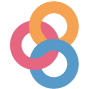)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![githubdev](https://open.vscode.dev/badges/open-in-vscode.svg)](https://github.dev/linogaliana/python-datascientist//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)

La pratique de la cartographie se fera, dans ce cours, en répliquant des cartes qu'on peut trouver sur
la page de l'*open-data* de la ville de Paris 
[ici](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name).

Produire de belles cartes demande du temps mais aussi du bon sens. En fonction de la structure des données, certaines représentations sont à éviter voire à exclure. L'excellent guide [disponible ici](https://juliedjidji.github.io/memocarto/semio.html) propose quelques règles et évoque les erreurs à éviter lorsqu'on désire effectuer des
représentations spatiales. 


Ce TP vise à initier:

* Au module graphique de [geopandas](https://geopandas.org/mapping.html) ainsi qu'aux packages [geoplot](https://residentmario.github.io/geoplot/index.html) et
[contextily](https://contextily.readthedocs.io/en/latest/intro_guide.html) pour la construction de cartes figées. `geoplot` est construit sur `seaborn` et constitue ainsi une extension des graphiques de base.
* Au package [folium](https://python-visualization.github.io/folium/) qui est un point d'accès vers la librairie JavaScript [leaflet](https://leafletjs.com/) permettant de produire des cartes interactives

Les données utilisées sont :

* Un sous-ensemble des données de [paris open data](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name) a été mis à disposition
sur {{< githubrepo >}} pour faciliter l'import (élimination des colonnes
qui ne nous servirons pas mais ralentissent l'import)
* [La localisation précise des stations](https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr)
* [Arrondissements parisiens](https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr)

Dans la première partie, nous allons utiliser les packages suivants:


In [ ]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import geoplot
import matplotlib.pyplot as plt
import folium

Certaines librairies géographiques dépendent de `rtree` qui est parfois difficile à installer. Pour installer `rtree`, le mieux est d'utiliser `anaconda`.

Installations préalables : 


In [ ]:
# Sur anaconda
conda install rtree --yes

In [ ]:
# Sur colab
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
!pip install geoplot

## Première carte avec l'API `matplotlib` de `geopandas`

{{% panel status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 1: Importer les données**

Importer les données de compteurs de vélos en deux temps.

1. D'abord, les comptages peuvent être trouvés à l'adresse <https://github.com/linogaliana/python-datascientist/raw/master/data/bike.csv>. :warning: Il s'agit de données
compressées au format `gzip`, il faut donc utiliser l'option `compression`. Nommer cet objet `comptages`.



2. Importer les données de localisation des compteurs à partir de l'url <https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. Nommer cet objet `compteurs`.


3. On va également utiliser les données d'arrondissements de la ville de Paris. Importer ces données depuis <https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. Nommer cet objet `arrondissements`.



4. Utiliser la méthode `plot` pour représenter les localisations des compteurs dans l'espace. C'est, on peut l'avouer, peu informatif sans apport extérieur. Il va donc falloir travailler un peu l'esthétique



On serait tenté de faire un *merge* de la base compteurs et comptages. En l'occurrence, il s'agirait d'un produit cartésien puisqu'il s'agit de faire exploser la base spatiale. Avec des données spatiales, c'est souvent une très mauvaise idée. Cela duplique les points, créant des difficultés à représenter les données mais aussi ralentit les calculs. Sauf à utiliser la méthode `dissolve` (qui va agréger *k* fois la même géométrie...), les géométries sont perdues lorsqu'on effectue des `groupby`.  



Maintenant, tout est prêt pour une première carte. `matplotlib` fonctionne selon
le principe des couches. On va de la couche la plus lointaine à celle le plus
en surface. L'exception est lorsqu'on ajoute un fond de carte `contextily` via
`ctx.add_basemap`: on met cet appel en dernier. 

{{% panel status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 2: Première carte**

Représenter une carte des `compteurs` avec le fonds de carte des `arrondissements`

  * Faire attention à avoir des arrondissements dont l'intérieur est transparent (argument à utiliser: `facecolor`).
  * Faire des bordures d'arrondissements noires et affichez les compteurs en rouge.
  * Pour obtenir un graphique plus grand, vous pouvez utiliser l'argument `figsize = (10,10)`.
  * Pour les localisations, les points doivent être rouges en étant plus transparent au centre (argument à utiliser: `alpha`) 



Vous devriez obtenir cette carte:




{{% panel status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 3 : Ajouter un fonds de carte avec contextily**

Repartir de la carte précédente.

1. Utiliser `ctx.add_basemap` pour ajouter un fonds de carte. Pour ne pas afficher les axes, vous pouvez utiliser `ax.set_axis_off()`.

:warning: *Par défaut, `contextily` désire un système de projection (crs) qui est le Web Mercator (epsg: 3857). Il faut changer la valeur de l'argument `crs`.*

:warning: *Avec les versions anciennes des packages, il faut utiliser `.to_string` sur un objet CRS pour qu'il soit reconnu par `contextily`. Sur des versions récentes, la valeur numérique du code EPSG est suffisante.*




2. Trouver un fonds de carte plus esthétique, qui permette de visualiser les grands axes, parmi ceux possibles. Pour tester l'esthétique, vous pouvez utiliser [cet url](http://leaflet-extras.github.io/leaflet-providers/preview/index.html). La documentation de référence sur les tuiles disponibles est [ici](https://contextily.readthedocs.io/en/latest/providers_deepdive.html) 


Le principe de la *heatmap* est de construire, à partir d'un nuage de point bidimensionnel, une distribution 2D lissée. La méthode repose sur les estimateurs à noyaux qui sont des méthodes de lissage local. 


Pour le moment, la fonction  `geoplot.kdeplot` n'incorpore pas toutes les fonctionalités de `seaborn.kdeplot`. Pour être en mesure de construire une `heatmap` avec des données pondérées (cf. [cette issue dans le dépôt seaborn](https://github.com/mwaskom/seaborn/issues/1364)), il y a une astuce. Il faut simuler *k* points de valeur 1 autour de la localisation observée. La fonction ci-dessous, qui m'a été bien utile, est pratique


In [ ]:
import numpy as np
def expand_points(shapefile,
                  index_var = "grid_id",
                  weight_var = 'prop',
                  radius_sd = 100,
                  crs = 2154):
    """
    Multiply number of points to be able to have a weighted heatmap
    :param shapefile: Shapefile to consider
    :param index_var: Variable name to set index
    :param weight_var: Variable that should be used
    :param radius_sd: Standard deviation for the radius of the jitter
    :param crs: Projection system that should be used. Recommended option
      is Lambert 93 because points will be jitterized using meters
    :return:
      A geopandas point object with as many points by index as weight
    """

    shpcopy = shapefile
    shpcopy = shpcopy.set_index(index_var)
    shpcopy['npoints'] = np.ceil(shpcopy[weight_var])
    shpcopy['geometry'] = shpcopy['geometry'].centroid
    shpcopy['x'] = shpcopy.geometry.x
    shpcopy['y'] = shpcopy.geometry.y
    shpcopy = shpcopy.to_crs(crs)
    shpcopy = shpcopy.loc[np.repeat(shpcopy.index.values, shpcopy.npoints)]
    shpcopy['x'] = shpcopy['x'] + np.random.normal(0, radius_sd, shpcopy.shape[0])
    shpcopy['y'] = shpcopy['y'] + np.random.normal(0, radius_sd, shpcopy.shape[0])

    gdf = gpd.GeoDataFrame(
        shpcopy,
        geometry = gpd.points_from_xy(shpcopy.x, shpcopy.y),
        crs = crs)

    return gdf

{{% panel status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 4 : Data cleaning avant de pouvoir faire une heatmap**

1. Calculer le trafic moyen, pour chaque station, entre 7 heures et 10 heures (bornes incluses) et nommer cet objet `df1`. Faire la même chose, en nommant `df2`, pour le trafic entre 17 et 20 heures (bornes incluses)



2. Nous allons désormais préparer les données de manière à faire une heatmap. Après avoir compris ce que permet de faire la fonction `expand_points` ci-dessus, créer une fonction `explode_data` qui suive les étapes suivantes. 
  + Convertir un DataFrame dans le système de projection Lambert 93 (epsg: 2154)
  + Appliquer `expand_points` aux noms de variable adéquats. Vous pouvez fixer la valeur de `radius_sd` à `100`. 
  + Reconvertir l'output au format WGS84 (epsg: 4326)



3. Appliquer cette fonction à `df1` et `df2`





**Exercice 5 : Heatmap, enfin !**

Représenter, pour ces deux moments de la journée, la `heatmap` du trafic de vélo avec `geoplot.kdeplot`. Pour cela :

- Appliquer la fonction `geoplot.kdeplot` avec comme consignes :
    + d'utiliser les arguments `shade=True` et `shade_lowest=True` pour colorer l'intérieur des courbes de niveaux obtenues ; 
    + d'utiliser une palette de couleur rouge avec une transparence modérée (`alpha = 0.6`)
    + d'utiliser l'argument `clip` pour ne pas déborder hors de Paris (en cas de doute, se référer à l'aide de `geoplot.kdeplot`)
    + L'argument `bw` (pour *bandwidth*) détermine le plus ou moins fort lissage spatial. Vous pouvez partir d'un bandwidth égal à 0.01 et le faire varier pour voir l'effet sur le résultat 
    
- Ne pas oublier d'ajouter les arrondissements. Avec `geoplot`, il faut utiliser `geoplot.polyplot`. 







## Des cartes réactives grâce à `folium`

De plus en plus de données de visualisation reposent sur la cartographie réactive. Que ce soit dans l'exploration des données ou dans la représentation finale de résultats, la cartographie réactive est très appréciable. 

`folium` offre une interface très flexible et très facile à prendre à main. Les cartes sont construites grâce à la librairie JavaScript `Leaflet.js` mais, sauf si on désire aller loin dans la customisation du résultat, il n'est pas nécessaire d'avoir des notions dans le domaine. 

Un objet folium se construit par couche. La première est l'initialisation de la carte. Les couches suivantes sont les éléments à mettre en valeur. L'initialisation de la carte nécessite la définition d'un point central (paramètre `location`) et d'un zoom de départ (`zoom_start`). Plutôt que de fournir manuellement le point central et le zoom on peut :

1. Déterminer le point central en construisant des colonnes longitudes et latitudes et en prenant la moyenne de celles-ci ;
2. Utiliser la méthode `fit_bounds` qui cale la carte sur les coins sud-ouest et nord-est. En supposant que la carte s'appelle `m`, on fera `m.fit_bounds([sw, ne])`

Le bout de code suivant permet de calculer le centre de la carte


In [ ]:
compteurs['lon'] = compteurs.geometry.x
compteurs['lat'] = compteurs.geometry.y
center = compteurs[['lat', 'lon']].mean().values.tolist()
print(center)

```
## [48.856288029999995, 2.34339106]
```

Alors que le code suivant permet de calculer les coins:


In [ ]:
sw = compteurs[['lat', 'lon']].min().values.tolist()
ne = compteurs[['lat', 'lon']].max().values.tolist()
print(sw)

```
## [48.82024, 2.26542]
```

In [ ]:
print(ne)

```
## [48.89696, 2.40969]
```

Si un fond gris s'affiche, c'est qu'il y a un problème de localisation. Cela provient généralement d'un problème de projection ou d'une inversion des longitudes et latitudes. 

Les longitudes représentent les *x* (axe ouest-est) et les latitudes *y* (axe sud-nord). De manière contrintuitive, `folium` attend qu'on lui fournisse les données sous la forme `[latitude, longitude]` donc `[y,x]`


**Exercice 6 : Visualiser la localisation des stations**

1. Calculer le centre `center`de la carte des données `compteurs`. Il s'obtient en agrègeant l'ensemble des géométries, calculant le centroid et récupèrant la valeur sous forme de liste. Avec une logique similaire, calculez les bornes du sud-ouest `sw` et du nord-est `ne` de la carte. 


2. Représenter la localisation des stations en utilisant un zoom optimal. 





La carte obtenue doit ressembler à la suivante:

<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" data-html=%3C%21DOCTYPE%20html%3E%0A%3Chead%3E%20%20%20%20%0A%20%20%20%20%3Cmeta%20http-equiv%3D%22content-type%22%20content%3D%22text/html%3B%20charset%3DUTF-8%22%20/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%3Cscript%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20L_NO_TOUCH%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20L_DISABLE_3D%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%3C/script%3E%0A%20%20%20%20%0A%20%20%20%20%3Cstyle%3Ehtml%2C%20body%20%7Bwidth%3A%20100%25%3Bheight%3A%20100%25%3Bmargin%3A%200%3Bpadding%3A%200%3B%7D%3C/style%3E%0A%20%20%20%20%3Cstyle%3E%23map%20%7Bposition%3Aabsolute%3Btop%3A0%3Bbottom%3A0%3Bright%3A0%3Bleft%3A0%3B%7D%3C/style%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//code.jquery.com/jquery-1.12.4.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js%22%3E%3C/script%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css%22/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cmeta%20name%3D%22viewport%22%20content%3D%22width%3Ddevice-width%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20initial-scale%3D1.0%2C%20maximum-scale%3D1.0%2C%20user-scalable%3Dno%22%20/%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cstyle%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23map_ceab5b12dff842da8ed0ab3b47c5ba00%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20position%3A%20relative%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20width%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20height%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20left%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20top%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C/style%3E%0A%20%20%20%20%20%20%20%20%0A%3C/head%3E%0A%3Cbody%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cdiv%20class%3D%22folium-map%22%20id%3D%22map_ceab5b12dff842da8ed0ab3b47c5ba00%22%20%3E%3C/div%3E%0A%20%20%20%20%20%20%20%20%0A%3C/body%3E%0A%3Cscript%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20map_ceab5b12dff842da8ed0ab3b47c5ba00%20%3D%20L.map%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22map_ceab5b12dff842da8ed0ab3b47c5ba00%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20center%3A%20%5B48.856288029999995%2C%202.34339106%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20crs%3A%20L.CRS.EPSG3857%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoom%3A%2010%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoomControl%3A%20true%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20preferCanvas%3A%20false%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%0A%20%20%20%20%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20tile_layer_22e6f4e8bfdd4e249b5aec39f3fda458%20%3D%20L.tileLayer%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22https%3A//stamen-tiles-%7Bs%7D.a.ssl.fastly.net/toner/%7Bz%7D/%7Bx%7D/%7By%7D.png%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22attribution%22%3A%20%22Map%20tiles%20by%20%5Cu003ca%20href%3D%5C%22http%3A//stamen.com%5C%22%5Cu003eStamen%20Design%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//creativecommons.org/licenses/by/3.0%5C%22%5Cu003eCC%20BY%203.0%5Cu003c/a%5Cu003e.%20Data%20by%20%5Cu0026copy%3B%20%5Cu003ca%20href%3D%5C%22http%3A//openstreetmap.org%5C%22%5Cu003eOpenStreetMap%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//www.openstreetmap.org/copyright%5C%22%5Cu003eODbL%5Cu003c/a%5Cu003e.%22%2C%20%22detectRetina%22%3A%20false%2C%20%22maxNativeZoom%22%3A%2018%2C%20%22maxZoom%22%3A%2018%2C%20%22minZoom%22%3A%200%2C%20%22noWrap%22%3A%20false%2C%20%22opacity%22%3A%201%2C%20%22subdomains%22%3A%20%22abc%22%2C%20%22tms%22%3A%20false%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_bf27b38582ed4d82a77c25206b93d759%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846099%2C%202.375456%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e9c1b1332bc545049ef1c11a63310f9f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ac431252924441ad8501885d5e275eab%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ac431252924441ad8501885d5e275eab%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20boulevard%20Diderot%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e9c1b1332bc545049ef1c11a63310f9f.setContent%28html_ac431252924441ad8501885d5e275eab%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_bf27b38582ed4d82a77c25206b93d759.bindPopup%28popup_e9c1b1332bc545049ef1c11a63310f9f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_3c23c459e21541e986722c93465be0b9%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84015%2C%202.26733%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ed430109eaea465fadc648b20eee309d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6c3f9c04afb94bda96efed85c445cb6b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6c3f9c04afb94bda96efed85c445cb6b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ed430109eaea465fadc648b20eee309d.setContent%28html_6c3f9c04afb94bda96efed85c445cb6b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_3c23c459e21541e986722c93465be0b9.bindPopup%28popup_ed430109eaea465fadc648b20eee309d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ee3378ecd06a4556b7bb154f34bcd7e2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.889046%2C%202.374872%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5a7999b5994a460d91e6ae7a8c232c26%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e6401fd5f1d14de9a3d666548f67a653%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e6401fd5f1d14de9a3d666548f67a653%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20avenue%20de%20Flandre%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5a7999b5994a460d91e6ae7a8c232c26.setContent%28html_e6401fd5f1d14de9a3d666548f67a653%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ee3378ecd06a4556b7bb154f34bcd7e2.bindPopup%28popup_5a7999b5994a460d91e6ae7a8c232c26%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_64bca19e8d7045a99fa63ba0771db893%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5dcdc1f5a7b04c849129549681b77583%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_95a70323d7e847438098c8b33d76922e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_95a70323d7e847438098c8b33d76922e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5dcdc1f5a7b04c849129549681b77583.setContent%28html_95a70323d7e847438098c8b33d76922e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_64bca19e8d7045a99fa63ba0771db893.bindPopup%28popup_5dcdc1f5a7b04c849129549681b77583%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0c8fa9cb750046dd93d6fa55484fb9eb%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83521%2C%202.33307%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5a085d7c120b4619bdeea75373177b76%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_dfd6b3bb2d284ff3bcafa46531f63b52%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_dfd6b3bb2d284ff3bcafa46531f63b52%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E106%20avenue%20Denfert%20Rochereau%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5a085d7c120b4619bdeea75373177b76.setContent%28html_dfd6b3bb2d284ff3bcafa46531f63b52%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0c8fa9cb750046dd93d6fa55484fb9eb.bindPopup%28popup_5a085d7c120b4619bdeea75373177b76%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_97911d46208e467ca16e2babfc30e17e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_39f1993bc3404a3da894399029aba219%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f5b7cd62c9e24155819451dea0118559%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f5b7cd62c9e24155819451dea0118559%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_39f1993bc3404a3da894399029aba219.setContent%28html_f5b7cd62c9e24155819451dea0118559%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_97911d46208e467ca16e2babfc30e17e.bindPopup%28popup_39f1993bc3404a3da894399029aba219%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_3f8f424cd87d42819eac6d1961f4aefe%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86357%2C%202.32203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cb030c7dae31452198c3204340839a62%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6d431e79cc044f13b1b1038d1e2dc0bb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6d431e79cc044f13b1b1038d1e2dc0bb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20des%20Tuileries%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cb030c7dae31452198c3204340839a62.setContent%28html_6d431e79cc044f13b1b1038d1e2dc0bb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_3f8f424cd87d42819eac6d1961f4aefe.bindPopup%28popup_cb030c7dae31452198c3204340839a62%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_dd50e954428a42dfba0d74b51c8c27f9%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.842091%2C%202.301%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_555903603c964c1ea6139a5b309ec153%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5c886b4cd2294da0871125373f19bb61%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5c886b4cd2294da0871125373f19bb61%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E129%20rue%20Lecourbe%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_555903603c964c1ea6139a5b309ec153.setContent%28html_5c886b4cd2294da0871125373f19bb61%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_dd50e954428a42dfba0d74b51c8c27f9.bindPopup%28popup_555903603c964c1ea6139a5b309ec153%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_99c18b5f8b114ecc87461969c7b47d20%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8234e7ddd8a6438594080049177a57be%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a460004bfdd94a11b358b9234aca140e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a460004bfdd94a11b358b9234aca140e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8234e7ddd8a6438594080049177a57be.setContent%28html_a460004bfdd94a11b358b9234aca140e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_99c18b5f8b114ecc87461969c7b47d20.bindPopup%28popup_8234e7ddd8a6438594080049177a57be%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9e2675838ee34c1b9b4726510c72ba3d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2c1ed6e05e1b43b8851c92a5abb99b9d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_37a808a51ca64301927d6cd4a4e983b7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_37a808a51ca64301927d6cd4a4e983b7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2c1ed6e05e1b43b8851c92a5abb99b9d.setContent%28html_37a808a51ca64301927d6cd4a4e983b7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9e2675838ee34c1b9b4726510c72ba3d.bindPopup%28popup_2c1ed6e05e1b43b8851c92a5abb99b9d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_1d7d261b3edb4f1a9c0f455bf898e139%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86149%2C%202.37376%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4eda37f062504fbbbf7ca479f68144d3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0ae08ab274b443cbaba80e5ea06d9f5b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0ae08ab274b443cbaba80e5ea06d9f5b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E67%20boulevard%20Voltaire%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4eda37f062504fbbbf7ca479f68144d3.setContent%28html_0ae08ab274b443cbaba80e5ea06d9f5b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_1d7d261b3edb4f1a9c0f455bf898e139.bindPopup%28popup_4eda37f062504fbbbf7ca479f68144d3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9249e1985e7246c1ad57e90b3ff56ba8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830449%2C%202.353199%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4059580d1ed34553bcb3158f41495e56%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8c3cd01e40e141cabcae04423c273c50%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8c3cd01e40e141cabcae04423c273c50%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Auguste%20Blanqui%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4059580d1ed34553bcb3158f41495e56.setContent%28html_8c3cd01e40e141cabcae04423c273c50%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9249e1985e7246c1ad57e90b3ff56ba8.bindPopup%28popup_4059580d1ed34553bcb3158f41495e56%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_18c6ef3de69f4d2b9ad8c842b6bb8146%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.840801%2C%202.333233%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6b41686713384939942fdacfa79fa7a3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6a22b1d2a89847dd987a3cffb80e47e5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6a22b1d2a89847dd987a3cffb80e47e5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E152%20boulevard%20du%20Montparnasse%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6b41686713384939942fdacfa79fa7a3.setContent%28html_6a22b1d2a89847dd987a3cffb80e47e5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_18c6ef3de69f4d2b9ad8c842b6bb8146.bindPopup%28popup_6b41686713384939942fdacfa79fa7a3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_38560dc680f847afb63654bf406e00ce%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89696%2C%202.34538%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2dd97d703e52491bbcd9ebf549990109%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0e3349fdd08a4be7a8e3055080c60c85%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0e3349fdd08a4be7a8e3055080c60c85%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E69%20Boulevard%20Ornano%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2dd97d703e52491bbcd9ebf549990109.setContent%28html_0e3349fdd08a4be7a8e3055080c60c85%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_38560dc680f847afb63654bf406e00ce.bindPopup%28popup_2dd97d703e52491bbcd9ebf549990109%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7c94644a47cf45408d25faad1308b618%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8b7abcd85ab04eda8cd2fdc2a4e0331a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5d6c6591e4b04dd3a62fb9b616cb93f6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5d6c6591e4b04dd3a62fb9b616cb93f6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8b7abcd85ab04eda8cd2fdc2a4e0331a.setContent%28html_5d6c6591e4b04dd3a62fb9b616cb93f6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7c94644a47cf45408d25faad1308b618.bindPopup%28popup_8b7abcd85ab04eda8cd2fdc2a4e0331a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_fe9220d8a4fd4122ad42b76a74977714%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86179%2C%202.32014%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a2f9fb01303b4668ad2208d6e7a0cadf%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1e7e161ce3e14aa18fe27f41e570f2f0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1e7e161ce3e14aa18fe27f41e570f2f0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E243%20boulevard%20Saint%20Germain%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a2f9fb01303b4668ad2208d6e7a0cadf.setContent%28html_1e7e161ce3e14aa18fe27f41e570f2f0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_fe9220d8a4fd4122ad42b76a74977714.bindPopup%28popup_a2f9fb01303b4668ad2208d6e7a0cadf%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_907965adabcc4b29974bbf9a43b7936e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0fffaeae59db414c922729ebe8c07a8c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b07cdb7d73ec4df2b010110fa4b339cd%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b07cdb7d73ec4df2b010110fa4b339cd%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0fffaeae59db414c922729ebe8c07a8c.setContent%28html_b07cdb7d73ec4df2b010110fa4b339cd%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_907965adabcc4b29974bbf9a43b7936e.bindPopup%28popup_0fffaeae59db414c922729ebe8c07a8c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b69b929c41e34ab9894fb01a0d461fe2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88529%2C%202.32666%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8d1ea7cbecce47c5b085abeededf2762%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_901d9580f68d476eb898783d30f20acf%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_901d9580f68d476eb898783d30f20acf%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E20%20Avenue%20de%20Clichy%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8d1ea7cbecce47c5b085abeededf2762.setContent%28html_901d9580f68d476eb898783d30f20acf%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b69b929c41e34ab9894fb01a0d461fe2.bindPopup%28popup_8d1ea7cbecce47c5b085abeededf2762%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8279661cbf4b41c3a78106a7df2f25d2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b8b56929c48845c89940e701b043a9e1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c4cf574d5ebc4d9cab1f6148dce8d881%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c4cf574d5ebc4d9cab1f6148dce8d881%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b8b56929c48845c89940e701b043a9e1.setContent%28html_c4cf574d5ebc4d9cab1f6148dce8d881%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8279661cbf4b41c3a78106a7df2f25d2.bindPopup%28popup_b8b56929c48845c89940e701b043a9e1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8b673b0eda7d430f8a2f1f55d10d108b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82682%2C%202.38465%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_276f27289ca949489cabeb0dd517afb6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b0cf873fb2b449f18ae99de189fabd84%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b0cf873fb2b449f18ae99de189fabd84%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_276f27289ca949489cabeb0dd517afb6.setContent%28html_b0cf873fb2b449f18ae99de189fabd84%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8b673b0eda7d430f8a2f1f55d10d108b.bindPopup%28popup_276f27289ca949489cabeb0dd517afb6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_723f5f94d4a244cbbe0e7dd05c904f4f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86357%2C%202.32203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fb302e264c1a4f2e946c0387bc159ea5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_675a183a5f1c4137985772d5614075b9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_675a183a5f1c4137985772d5614075b9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20des%20Tuileries%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fb302e264c1a4f2e946c0387bc159ea5.setContent%28html_675a183a5f1c4137985772d5614075b9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_723f5f94d4a244cbbe0e7dd05c904f4f.bindPopup%28popup_fb302e264c1a4f2e946c0387bc159ea5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_5ddff472859b464a8201e05c59a747d5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869831%2C%202.307076%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a9621f7a182f46fabc15be6f7031afe9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9dfb9747fbdb47cba988403994120203%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9dfb9747fbdb47cba988403994120203%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E33%20avenue%20des%20Champs%20Elys%C3%A9es%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a9621f7a182f46fabc15be6f7031afe9.setContent%28html_9dfb9747fbdb47cba988403994120203%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_5ddff472859b464a8201e05c59a747d5.bindPopup%28popup_a9621f7a182f46fabc15be6f7031afe9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b9e0ef6dd68441a691506a083099341f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86282%2C%202.31061%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_531c6ccf5df84eb597e9d07447e16c42%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_23cb605dfa044266a5c2d139ea0126bb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_23cb605dfa044266a5c2d139ea0126bb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_531c6ccf5df84eb597e9d07447e16c42.setContent%28html_23cb605dfa044266a5c2d139ea0126bb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b9e0ef6dd68441a691506a083099341f.bindPopup%28popup_531c6ccf5df84eb597e9d07447e16c42%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0a01b28ff62b4a76a673b9947e1b56a8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86155%2C%202.37407%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1b17ec4c1ca9491c9bd9a54d95b2273a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2c78f389f8a342b5b240c2d9a63ab907%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2c78f389f8a342b5b240c2d9a63ab907%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Voltaire%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1b17ec4c1ca9491c9bd9a54d95b2273a.setContent%28html_2c78f389f8a342b5b240c2d9a63ab907%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0a01b28ff62b4a76a673b9947e1b56a8.bindPopup%28popup_1b17ec4c1ca9491c9bd9a54d95b2273a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c693adf849e445319043e5460ac1c468%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86057%2C%202.38886%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6776e423f6504b308aa41e8f9738458b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0a8f32d8db1c48388d24ba2299ad03d4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0a8f32d8db1c48388d24ba2299ad03d4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E26%20boulevard%20de%20M%C3%A9nilmontant%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6776e423f6504b308aa41e8f9738458b.setContent%28html_0a8f32d8db1c48388d24ba2299ad03d4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c693adf849e445319043e5460ac1c468.bindPopup%28popup_6776e423f6504b308aa41e8f9738458b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c6ada1d1e4c642c287aab889509dcf40%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_de9c997630324bca910e163ae5422bdd%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ff6125e3033b427585f5d000f69cb60b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ff6125e3033b427585f5d000f69cb60b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_de9c997630324bca910e163ae5422bdd.setContent%28html_ff6125e3033b427585f5d000f69cb60b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c6ada1d1e4c642c287aab889509dcf40.bindPopup%28popup_de9c997630324bca910e163ae5422bdd%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_1a54d7263c8e4a9480ec2c3a0d0ad317%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_219b722fd0854ca3b98ee5e1b7793538%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_aa4595375f2c4f08ac9dc7a213547c6c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_aa4595375f2c4f08ac9dc7a213547c6c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_219b722fd0854ca3b98ee5e1b7793538.setContent%28html_aa4595375f2c4f08ac9dc7a213547c6c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_1a54d7263c8e4a9480ec2c3a0d0ad317.bindPopup%28popup_219b722fd0854ca3b98ee5e1b7793538%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b0f553b8f4f741b790228c2877205cf1%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b36217361733492db03fbd914c765f17%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6ff87d9678e94863bfef8f31a96149a7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6ff87d9678e94863bfef8f31a96149a7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b36217361733492db03fbd914c765f17.setContent%28html_6ff87d9678e94863bfef8f31a96149a7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b0f553b8f4f741b790228c2877205cf1.bindPopup%28popup_b36217361733492db03fbd914c765f17%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ee04314852f147068a9cb84ca1340e76%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_bbda738255b94171ba0862f2decd489b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d21890cbf1b9402d9df7bc9a8f69a691%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d21890cbf1b9402d9df7bc9a8f69a691%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_bbda738255b94171ba0862f2decd489b.setContent%28html_d21890cbf1b9402d9df7bc9a8f69a691%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ee04314852f147068a9cb84ca1340e76.bindPopup%28popup_bbda738255b94171ba0862f2decd489b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_896c8d34bcba46d9a41a70d5db8ee038%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a90ed8ddf4b142db91fe6732fc302b97%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_98e260fec2444815a848e8dc26727edb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_98e260fec2444815a848e8dc26727edb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a90ed8ddf4b142db91fe6732fc302b97.setContent%28html_98e260fec2444815a848e8dc26727edb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_896c8d34bcba46d9a41a70d5db8ee038.bindPopup%28popup_a90ed8ddf4b142db91fe6732fc302b97%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_44626f557e2d4d33b17345b2392f9321%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83511%2C%202.33338%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_18e067e14ae04165a84200edd260c5a5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f4e69feb35d64e559c59ed3358cf6e08%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f4e69feb35d64e559c59ed3358cf6e08%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E97%20avenue%20Denfert%20Rochereau%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_18e067e14ae04165a84200edd260c5a5.setContent%28html_f4e69feb35d64e559c59ed3358cf6e08%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_44626f557e2d4d33b17345b2392f9321.bindPopup%28popup_18e067e14ae04165a84200edd260c5a5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_65da222fa2954fc8ab6e4c7a2c93f0e4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87451%2C%202.29215%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_321278d228014ae8b12d4041af49aa61%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_11249ad19929452d87d376176007203b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_11249ad19929452d87d376176007203b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E7%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_321278d228014ae8b12d4041af49aa61.setContent%28html_11249ad19929452d87d376176007203b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_65da222fa2954fc8ab6e4c7a2c93f0e4.bindPopup%28popup_321278d228014ae8b12d4041af49aa61%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d8479bb4455c410fa037eb0844e45d73%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.877726%2C%202.354926%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_807a204c86404ef285ca084590e4f4f4%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4036112284c04111886d195c9ba1938a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4036112284c04111886d195c9ba1938a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E102%20boulevard%20de%20Magenta%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_807a204c86404ef285ca084590e4f4f4.setContent%28html_4036112284c04111886d195c9ba1938a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d8479bb4455c410fa037eb0844e45d73.bindPopup%28popup_807a204c86404ef285ca084590e4f4f4%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_3b50b560b53a45f888ff15533ef8337b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.881626%2C%202.281203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_702017cf8f9c4526a72a8592752ee591%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a53eebe2ab7a4a71bfe3cfdd956de12b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a53eebe2ab7a4a71bfe3cfdd956de12b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2016%20avenue%20de%20la%20%20Porte%20des%20Ternes%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_702017cf8f9c4526a72a8592752ee591.setContent%28html_a53eebe2ab7a4a71bfe3cfdd956de12b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_3b50b560b53a45f888ff15533ef8337b.bindPopup%28popup_702017cf8f9c4526a72a8592752ee591%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_42668363079642da8929d6602ea2a1be%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2000d5bc16b846c3a39bda3d189a759d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a9d0b5cb988d4545a8485353e90f9af2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a9d0b5cb988d4545a8485353e90f9af2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2000d5bc16b846c3a39bda3d189a759d.setContent%28html_a9d0b5cb988d4545a8485353e90f9af2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_42668363079642da8929d6602ea2a1be.bindPopup%28popup_2000d5bc16b846c3a39bda3d189a759d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e59d654d563a4aec927bf5ae711262f4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83992%2C%202.26694%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c8e4449374294ad1b4d2348d3c291dc1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_62ae5249241740b7b4b23b352d06d964%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_62ae5249241740b7b4b23b352d06d964%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c8e4449374294ad1b4d2348d3c291dc1.setContent%28html_62ae5249241740b7b4b23b352d06d964%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e59d654d563a4aec927bf5ae711262f4.bindPopup%28popup_c8e4449374294ad1b4d2348d3c291dc1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f22e9faf67a440cc80216a13d4bc8ebc%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3fcba5f865ea4f2999a017ae3b23f33a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_58ea90d539984e7f86407d59792245ed%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_58ea90d539984e7f86407d59792245ed%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3fcba5f865ea4f2999a017ae3b23f33a.setContent%28html_58ea90d539984e7f86407d59792245ed%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f22e9faf67a440cc80216a13d4bc8ebc.bindPopup%28popup_3fcba5f865ea4f2999a017ae3b23f33a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_6ea567cf3ed54a18b81d717589d026fd%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_455db5a984ae45bbacad9b31193a02d9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a2e997d99ee34269ac93b700f4367fc8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a2e997d99ee34269ac93b700f4367fc8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_455db5a984ae45bbacad9b31193a02d9.setContent%28html_a2e997d99ee34269ac93b700f4367fc8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_6ea567cf3ed54a18b81d717589d026fd.bindPopup%28popup_455db5a984ae45bbacad9b31193a02d9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_668120074fce46439f00a051b2375a9c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83068%2C%202.35348%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3de81cb1bbb54e45877cd2d2f3086920%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f62445c9ed4d4a64acf8b79ef4af3087%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f62445c9ed4d4a64acf8b79ef4af3087%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20boulevard%20Auguste%20Blanqui%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3de81cb1bbb54e45877cd2d2f3086920.setContent%28html_f62445c9ed4d4a64acf8b79ef4af3087%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_668120074fce46439f00a051b2375a9c.bindPopup%28popup_3de81cb1bbb54e45877cd2d2f3086920%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d4bcae08239b441fbcbf72d9b0f2b77f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88926%2C%202.37472%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0f9840eaaf85414893d397ed33b29d89%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7e1a8cc9e6f34474b81abb5fcaa979dc%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7e1a8cc9e6f34474b81abb5fcaa979dc%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E87%20avenue%20de%20Flandre%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0f9840eaaf85414893d397ed33b29d89.setContent%28html_7e1a8cc9e6f34474b81abb5fcaa979dc%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d4bcae08239b441fbcbf72d9b0f2b77f.bindPopup%28popup_0f9840eaaf85414893d397ed33b29d89%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_bbb3be4be3dc49bdaa300f37b7485c7e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82024%2C%202.35902%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5d73390ae1b6479c946f82195e3bae45%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1fb28fca9b08468d8ef0bc102cce015c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1fb28fca9b08468d8ef0bc102cce015c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E180%20avenue%20d%27Italie%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5d73390ae1b6479c946f82195e3bae45.setContent%28html_1fb28fca9b08468d8ef0bc102cce015c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_bbb3be4be3dc49bdaa300f37b7485c7e.bindPopup%28popup_5d73390ae1b6479c946f82195e3bae45%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_95a72f83490e435b88bd3d43834cd757%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88529%2C%202.32666%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1b5b6fc4ee304e19bd0ccf461f3ef9e2%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d8a64e7b7c844133a43151a1a098c420%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d8a64e7b7c844133a43151a1a098c420%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E20%20Avenue%20de%20Clichy%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1b5b6fc4ee304e19bd0ccf461f3ef9e2.setContent%28html_d8a64e7b7c844133a43151a1a098c420%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_95a72f83490e435b88bd3d43834cd757.bindPopup%28popup_1b5b6fc4ee304e19bd0ccf461f3ef9e2%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7346d4686e6e4bc086000b46c908db31%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83977%2C%202.30198%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_82ebe733c696416ebf79bb89c3da6cb6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1183ff50d12e4110812152f8f9f78e8f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1183ff50d12e4110812152f8f9f78e8f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E254%20rue%20de%20Vaugirard%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_82ebe733c696416ebf79bb89c3da6cb6.setContent%28html_1183ff50d12e4110812152f8f9f78e8f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7346d4686e6e4bc086000b46c908db31.bindPopup%28popup_82ebe733c696416ebf79bb89c3da6cb6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e0f6e0cc739b4876a356d6797844bedb%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860852%2C%202.372279%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1eb2acb939c6466abe414fb5b2716d91%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_932f9b11bdef466ead8e24fafea9b43c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_932f9b11bdef466ead8e24fafea9b43c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E77%20boulevard%20Richard%20Lenoir%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1eb2acb939c6466abe414fb5b2716d91.setContent%28html_932f9b11bdef466ead8e24fafea9b43c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e0f6e0cc739b4876a356d6797844bedb.bindPopup%28popup_1eb2acb939c6466abe414fb5b2716d91%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8c1ec1a64e714e83ad0ca172668e9c2e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.840801%2C%202.333233%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_daf05717da464f40b408cc4da7c36f37%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_01296a083fda4b5393df912b6a200bdc%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_01296a083fda4b5393df912b6a200bdc%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E152%20boulevard%20du%20Montparnasse%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_daf05717da464f40b408cc4da7c36f37.setContent%28html_01296a083fda4b5393df912b6a200bdc%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8c1ec1a64e714e83ad0ca172668e9c2e.bindPopup%28popup_daf05717da464f40b408cc4da7c36f37%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f55e8f580afc482393c1ba985061886d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d326a9d13d2842c6a9459bc1f4518041%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_34d42766adf949e896362e827d514d60%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_34d42766adf949e896362e827d514d60%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d326a9d13d2842c6a9459bc1f4518041.setContent%28html_34d42766adf949e896362e827d514d60%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f55e8f580afc482393c1ba985061886d.bindPopup%28popup_d326a9d13d2842c6a9459bc1f4518041%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8aea80457e3e48e3854cbbfe475b137a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86284%2C%202.310345%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_95413bf2193c411998df560be971b905%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f839ed02687c43a5897956508dae1357%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f839ed02687c43a5897956508dae1357%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_95413bf2193c411998df560be971b905.setContent%28html_f839ed02687c43a5897956508dae1357%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8aea80457e3e48e3854cbbfe475b137a.bindPopup%28popup_95413bf2193c411998df560be971b905%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b65d605bb631492bb9a286c4f9e87f95%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_15f0516312d2434aad0717ecbb0819bc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_768838c5d254422babc51c891c3f233e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_768838c5d254422babc51c891c3f233e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_15f0516312d2434aad0717ecbb0819bc.setContent%28html_768838c5d254422babc51c891c3f233e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b65d605bb631492bb9a286c4f9e87f95.bindPopup%28popup_15f0516312d2434aad0717ecbb0819bc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9e7b2039cd1240969dd089a6e2213289%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3e7705ddaa2745e2ab6fdaa41344afec%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2092b99c5aa449b1a758b09b795c64d3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2092b99c5aa449b1a758b09b795c64d3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3e7705ddaa2745e2ab6fdaa41344afec.setContent%28html_2092b99c5aa449b1a758b09b795c64d3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9e7b2039cd1240969dd089a6e2213289.bindPopup%28popup_3e7705ddaa2745e2ab6fdaa41344afec%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_6ce45bf6b060499580ca812996b17150%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ca0cfbaa6ec243cdaf844dd46333bf6c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7c984561143140c7ba89bb74179b1b3a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7c984561143140c7ba89bb74179b1b3a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ca0cfbaa6ec243cdaf844dd46333bf6c.setContent%28html_7c984561143140c7ba89bb74179b1b3a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_6ce45bf6b060499580ca812996b17150.bindPopup%28popup_ca0cfbaa6ec243cdaf844dd46333bf6c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_56f710f784c94d34b00819d069cbd625%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87756%2C%202.35535%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1c740c47e7194bdb87756654038d46d8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ec03a82f654d44209966166c1025d025%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ec03a82f654d44209966166c1025d025%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E89%20boulevard%20de%20Magenta%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1c740c47e7194bdb87756654038d46d8.setContent%28html_ec03a82f654d44209966166c1025d025%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_56f710f784c94d34b00819d069cbd625.bindPopup%28popup_1c740c47e7194bdb87756654038d46d8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_67ea2574e4384a478a6d0f9e9c2cee65%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8cd6f88654e44f6d8da665aef0137e22%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1e1cb4d5f6ea4744b3d0d36d82ea71ba%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1e1cb4d5f6ea4744b3d0d36d82ea71ba%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8cd6f88654e44f6d8da665aef0137e22.setContent%28html_1e1cb4d5f6ea4744b3d0d36d82ea71ba%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_67ea2574e4384a478a6d0f9e9c2cee65.bindPopup%28popup_8cd6f88654e44f6d8da665aef0137e22%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_41ce3ab43e024c2fa000302792c2f8cc%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_aee583c90a994be882218c32d5cb883f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c233de2139fa427694a79c836be9e0d3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c233de2139fa427694a79c836be9e0d3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_aee583c90a994be882218c32d5cb883f.setContent%28html_c233de2139fa427694a79c836be9e0d3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_41ce3ab43e024c2fa000302792c2f8cc.bindPopup%28popup_aee583c90a994be882218c32d5cb883f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_1c38fc72a8b04c94b32dcd0aed0264be%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9d3d1fdb949e4b56877362992cc282d5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b8fc547fe71541a3bf89c76202b5503a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b8fc547fe71541a3bf89c76202b5503a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9d3d1fdb949e4b56877362992cc282d5.setContent%28html_b8fc547fe71541a3bf89c76202b5503a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_1c38fc72a8b04c94b32dcd0aed0264be.bindPopup%28popup_9d3d1fdb949e4b56877362992cc282d5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b0da4b973e5a47b4a748e235a51405ec%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3af6cd67f8954c27afa30018f762f30e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9fbb3c88e69f4c8daa2d11cde940e562%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9fbb3c88e69f4c8daa2d11cde940e562%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3af6cd67f8954c27afa30018f762f30e.setContent%28html_9fbb3c88e69f4c8daa2d11cde940e562%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b0da4b973e5a47b4a748e235a51405ec.bindPopup%28popup_3af6cd67f8954c27afa30018f762f30e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a1aa5373d47a4335a8f74b2efcfee81f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_bb66e4e2c9ed4949877fdd22325c551b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_881eb8c3d41c4bc295467bc7fa1715f9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_881eb8c3d41c4bc295467bc7fa1715f9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_bb66e4e2c9ed4949877fdd22325c551b.setContent%28html_881eb8c3d41c4bc295467bc7fa1715f9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a1aa5373d47a4335a8f74b2efcfee81f.bindPopup%28popup_bb66e4e2c9ed4949877fdd22325c551b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9e0561f004d440c0942b818c44823d7f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87813%2C%202.3497%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2c813300ae7e44dbbb37537d50d99299%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3fb9e7e459164bff9ad85f5289a54bc1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3fb9e7e459164bff9ad85f5289a54bc1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E100%20Lafayette%20100%20Lafayette%20%232%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2c813300ae7e44dbbb37537d50d99299.setContent%28html_3fb9e7e459164bff9ad85f5289a54bc1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9e0561f004d440c0942b818c44823d7f.bindPopup%28popup_2c813300ae7e44dbbb37537d50d99299%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ecc116c94a9b4792aa2e9ea651660240%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88181%2C%202.281546%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3e200778395840fc8448820264aa6283%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c142d523da77416b9297a7f1ca53ba90%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c142d523da77416b9297a7f1ca53ba90%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E16%20avenue%20de%20la%20Porte%20des%20Ternes%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3e200778395840fc8448820264aa6283.setContent%28html_c142d523da77416b9297a7f1ca53ba90%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ecc116c94a9b4792aa2e9ea651660240.bindPopup%28popup_3e200778395840fc8448820264aa6283%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_107653b23a46433a929611cdcfff8a7e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f41ff3415fa54f72adaf4a55d88743e9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ace48c92236b4f97a301cf475b7d453a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ace48c92236b4f97a301cf475b7d453a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f41ff3415fa54f72adaf4a55d88743e9.setContent%28html_ace48c92236b4f97a301cf475b7d453a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_107653b23a46433a929611cdcfff8a7e.bindPopup%28popup_f41ff3415fa54f72adaf4a55d88743e9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a7ba6526e131467a947e2791c5d8190c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851131%2C%202.345678%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7ee377b6f3a046028bee64269020fac7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_92c7c1c8252f43e9a96fb417ea1e93da%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_92c7c1c8252f43e9a96fb417ea1e93da%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E30%20rue%20Saint%20Jacques%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7ee377b6f3a046028bee64269020fac7.setContent%28html_92c7c1c8252f43e9a96fb417ea1e93da%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a7ba6526e131467a947e2791c5d8190c.bindPopup%28popup_7ee377b6f3a046028bee64269020fac7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_af92937fdd7148169058157b9f5a82ba%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.843435%2C%202.383378%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5f0f100ef11d46bda66759403403c4b5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_421f62eac6054b3bb55ed7382a7d496f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_421f62eac6054b3bb55ed7382a7d496f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E135%20avenue%20Daumesnil%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5f0f100ef11d46bda66759403403c4b5.setContent%28html_421f62eac6054b3bb55ed7382a7d496f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_af92937fdd7148169058157b9f5a82ba.bindPopup%28popup_5f0f100ef11d46bda66759403403c4b5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_42265302cf694f66921db92987ca7f7e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6e33335e13d64047bcb621764e156cf6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e340938427c94ccd952fedd7b5f7fbbe%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e340938427c94ccd952fedd7b5f7fbbe%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6e33335e13d64047bcb621764e156cf6.setContent%28html_e340938427c94ccd952fedd7b5f7fbbe%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_42265302cf694f66921db92987ca7f7e.bindPopup%28popup_6e33335e13d64047bcb621764e156cf6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_96f309aebde14c00a851fdac26995ecd%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86451%2C%202.40932%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f35406c8e39642d8aa7b1a203b923cb3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e8373f7754a043b5bb1c665598c644a3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e8373f7754a043b5bb1c665598c644a3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E2%20avenue%20de%20la%20Porte%20de%20Bagnolet%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f35406c8e39642d8aa7b1a203b923cb3.setContent%28html_e8373f7754a043b5bb1c665598c644a3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_96f309aebde14c00a851fdac26995ecd.bindPopup%28popup_f35406c8e39642d8aa7b1a203b923cb3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_51d1c42fdfc743d187fd5bcff38ffe61%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d48b66d7ec3747f28c1ce9ff57e6cdd9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6ebbce06561246b6905241d361f950ba%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6ebbce06561246b6905241d361f950ba%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d48b66d7ec3747f28c1ce9ff57e6cdd9.setContent%28html_6ebbce06561246b6905241d361f950ba%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_51d1c42fdfc743d187fd5bcff38ffe61.bindPopup%28popup_d48b66d7ec3747f28c1ce9ff57e6cdd9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_47d5e353ca974af1a170caf9b817da52%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fef81a5cd82b435bb8aeb4cd6fac92e4%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ab1b13b71a27422b83b5e047e6d4e5a2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ab1b13b71a27422b83b5e047e6d4e5a2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fef81a5cd82b435bb8aeb4cd6fac92e4.setContent%28html_ab1b13b71a27422b83b5e047e6d4e5a2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_47d5e353ca974af1a170caf9b817da52.bindPopup%28popup_fef81a5cd82b435bb8aeb4cd6fac92e4%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9dd24e74df6c4b91a9a2ab849ed39c3d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82658%2C%202.38409%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1917914e23234d98a574102485ed5301%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ce54d0ac001e4713b1954a31c9f66835%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ce54d0ac001e4713b1954a31c9f66835%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1917914e23234d98a574102485ed5301.setContent%28html_ce54d0ac001e4713b1954a31c9f66835%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9dd24e74df6c4b91a9a2ab849ed39c3d.bindPopup%28popup_1917914e23234d98a574102485ed5301%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_759b162be9084e218d1e7e237cf1a33e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8e601715b0114f529a7d7670214bf61d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1e107567baf04128aebdda14f863b95d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1e107567baf04128aebdda14f863b95d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8e601715b0114f529a7d7670214bf61d.setContent%28html_1e107567baf04128aebdda14f863b95d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_759b162be9084e218d1e7e237cf1a33e.bindPopup%28popup_8e601715b0114f529a7d7670214bf61d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ab7abca837434442bc7a284530bf2e4a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86373%2C%202.31973%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5ffda26155834ef291c52f3ae94b4622%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_00644b47d2014fa3a055ed0b1cb34f39%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_00644b47d2014fa3a055ed0b1cb34f39%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5ffda26155834ef291c52f3ae94b4622.setContent%28html_00644b47d2014fa3a055ed0b1cb34f39%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ab7abca837434442bc7a284530bf2e4a.bindPopup%28popup_5ffda26155834ef291c52f3ae94b4622%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a4ece9399157479398e6d0d0ed99185d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82108%2C%202.32537%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_025ebc4abf8c40c7aa3e94bd7c482645%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4703f87b341e4b869618b669686b42fc%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4703f87b341e4b869618b669686b42fc%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E3%20avenue%20de%20la%20Porte%20D%27Orl%C3%A9ans%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_025ebc4abf8c40c7aa3e94bd7c482645.setContent%28html_4703f87b341e4b869618b669686b42fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a4ece9399157479398e6d0d0ed99185d.bindPopup%28popup_025ebc4abf8c40c7aa3e94bd7c482645%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_94f68a5395e94a008cd2071c9c703586%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860528%2C%202.388364%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6184185c387f443786d58b33eca45c10%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6b2a4dcbec5c4bdfa2ca5d10d75ff283%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6b2a4dcbec5c4bdfa2ca5d10d75ff283%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E35%20boulevard%20de%20M%C3%A9nilmontant%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6184185c387f443786d58b33eca45c10.setContent%28html_6b2a4dcbec5c4bdfa2ca5d10d75ff283%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_94f68a5395e94a008cd2071c9c703586.bindPopup%28popup_6184185c387f443786d58b33eca45c10%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a2f51b054c9d430cbe144eda719c7fc4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83977%2C%202.30198%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_99021f50083543d0ab47af6d7e08fc66%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6cd94e1e7c5e411f8026c864bc5658bb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6cd94e1e7c5e411f8026c864bc5658bb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E254%20rue%20de%20Vaugirard%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_99021f50083543d0ab47af6d7e08fc66.setContent%28html_6cd94e1e7c5e411f8026c864bc5658bb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a2f51b054c9d430cbe144eda719c7fc4.bindPopup%28popup_99021f50083543d0ab47af6d7e08fc66%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_5b3535aed3a4476a9fa2634969a04ffe%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c1a84498e34248d3b686e107d1b9b154%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_00256b0ad5e34676b834c53437eb7758%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_00256b0ad5e34676b834c53437eb7758%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c1a84498e34248d3b686e107d1b9b154.setContent%28html_00256b0ad5e34676b834c53437eb7758%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_5b3535aed3a4476a9fa2634969a04ffe.bindPopup%28popup_c1a84498e34248d3b686e107d1b9b154%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f7e36e39098940248a4d5e196d4e684d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86378%2C%202.32003%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_53ba6d9bc4954bd78419c8fea81b0e5e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6ec9f6a14f754f23a9743f68d233b275%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6ec9f6a14f754f23a9743f68d233b275%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_53ba6d9bc4954bd78419c8fea81b0e5e.setContent%28html_6ec9f6a14f754f23a9743f68d233b275%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f7e36e39098940248a4d5e196d4e684d.bindPopup%28popup_53ba6d9bc4954bd78419c8fea81b0e5e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_3f1260c183ee419cb7f900919724dc86%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8106056752a44223ad94f555a19bac29%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d7aa70ca9fc64c7a9447dd88d904ec9b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d7aa70ca9fc64c7a9447dd88d904ec9b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8106056752a44223ad94f555a19bac29.setContent%28html_d7aa70ca9fc64c7a9447dd88d904ec9b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_3f1260c183ee419cb7f900919724dc86.bindPopup%28popup_8106056752a44223ad94f555a19bac29%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_27c9ca217a2048eaa4593b60787d9bde%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851525%2C%202.343298%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8fd12b0daa134f0ba45ac8747772de60%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3b835836d11246a797fe8339be90be2b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3b835836d11246a797fe8339be90be2b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Saint%20Michel%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8fd12b0daa134f0ba45ac8747772de60.setContent%28html_3b835836d11246a797fe8339be90be2b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_27c9ca217a2048eaa4593b60787d9bde.bindPopup%28popup_8fd12b0daa134f0ba45ac8747772de60%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b4bb06b1d7644b6088d4120c962fe359%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.896825%2C%202.345648%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_75e6957861dc4f9a8e1517152c6a36c1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_af7911bf2ab449439dc25d0675ef3b94%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_af7911bf2ab449439dc25d0675ef3b94%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E74%20Boulevard%20Ornano%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_75e6957861dc4f9a8e1517152c6a36c1.setContent%28html_af7911bf2ab449439dc25d0675ef3b94%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b4bb06b1d7644b6088d4120c962fe359.bindPopup%28popup_75e6957861dc4f9a8e1517152c6a36c1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_eb95e532a3c84d24a264c81ca2dd4b3b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87813%2C%202.3497%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e8472d03be5246aaaf23f99b50af7adf%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d0b3cbafdc534d7386660c991ff1976c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d0b3cbafdc534d7386660c991ff1976c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E100%20rue%20La%20Fayette%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e8472d03be5246aaaf23f99b50af7adf.setContent%28html_d0b3cbafdc534d7386660c991ff1976c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_eb95e532a3c84d24a264c81ca2dd4b3b.bindPopup%28popup_e8472d03be5246aaaf23f99b50af7adf%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f48c442bee98498d8778c97ecc6db42a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.874716%2C%202.292439%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_49dea2db81754d6188bd398aa760b81c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_85818e75ba9d4407bdd9f2790e3e044c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_85818e75ba9d4407bdd9f2790e3e044c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_49dea2db81754d6188bd398aa760b81c.setContent%28html_85818e75ba9d4407bdd9f2790e3e044c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f48c442bee98498d8778c97ecc6db42a.bindPopup%28popup_49dea2db81754d6188bd398aa760b81c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b4e3e379f79f4c85b73280c1e7cc9479%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_de328d96eda74088b0e9f75417da57eb%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b3e3bbefd75e4c1ba69da87f2199a3d4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b3e3bbefd75e4c1ba69da87f2199a3d4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_de328d96eda74088b0e9f75417da57eb.setContent%28html_b3e3bbefd75e4c1ba69da87f2199a3d4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b4e3e379f79f4c85b73280c1e7cc9479.bindPopup%28popup_de328d96eda74088b0e9f75417da57eb%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_bfad4ff7c6d2435eb3cae89aa14572f3%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82026%2C%202.3592%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b5756b7af95741fc89b5a99c63b3919c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0cd75a33d3d846b9805641904b5ba068%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0cd75a33d3d846b9805641904b5ba068%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E147%20avenue%20d%27Italie%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b5756b7af95741fc89b5a99c63b3919c.setContent%28html_0cd75a33d3d846b9805641904b5ba068%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_bfad4ff7c6d2435eb3cae89aa14572f3.bindPopup%28popup_b5756b7af95741fc89b5a99c63b3919c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b269767ed50d44a69aaef152c9154046%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_253f9b00d4164d358d61fd29427a2f65%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_97382201e90140fd8378fb21fa895735%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_97382201e90140fd8378fb21fa895735%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_253f9b00d4164d358d61fd29427a2f65.setContent%28html_97382201e90140fd8378fb21fa895735%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b269767ed50d44a69aaef152c9154046.bindPopup%28popup_253f9b00d4164d358d61fd29427a2f65%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ca63169a0faa4ecc90b570e19e033b80%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_869440f906c045db9da659d97189c8cb%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8eaa3a9d574f44afb6b15dd36058293b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8eaa3a9d574f44afb6b15dd36058293b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_869440f906c045db9da659d97189c8cb.setContent%28html_8eaa3a9d574f44afb6b15dd36058293b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ca63169a0faa4ecc90b570e19e033b80.bindPopup%28popup_869440f906c045db9da659d97189c8cb%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d6e5191f33ef4a0289a232a239fb07c8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87773%2C%202.3506%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_423a770faeca4ce3b04cd8025ae3dc47%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_60fd4594635f4740a69ed7e4042aaf74%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_60fd4594635f4740a69ed7e4042aaf74%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E105%20rue%20Lafayette%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_423a770faeca4ce3b04cd8025ae3dc47.setContent%28html_60fd4594635f4740a69ed7e4042aaf74%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d6e5191f33ef4a0289a232a239fb07c8.bindPopup%28popup_423a770faeca4ce3b04cd8025ae3dc47%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4952e48bf03f46bdb45e261d38385d8f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87773%2C%202.3506%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_854986a3154144bfa28b3b8f1433ba2e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0f4dfe05cb284517be07166b2325e68e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0f4dfe05cb284517be07166b2325e68e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E105%20rue%20La%20Fayette%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_854986a3154144bfa28b3b8f1433ba2e.setContent%28html_0f4dfe05cb284517be07166b2325e68e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4952e48bf03f46bdb45e261d38385d8f.bindPopup%28popup_854986a3154144bfa28b3b8f1433ba2e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_34862421a2db4f92bc59891bc093788c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_36d5f61785134f92b0fe988b2c0b1923%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_58296738ad214f40b79916eaf7541375%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_58296738ad214f40b79916eaf7541375%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_36d5f61785134f92b0fe988b2c0b1923.setContent%28html_58296738ad214f40b79916eaf7541375%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_34862421a2db4f92bc59891bc093788c.bindPopup%28popup_36d5f61785134f92b0fe988b2c0b1923%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_aecbbe5090e24f5280e5e31c74adb5d0%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7d72a969c9824869af470b0c18607444%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_44be3685bfcc4b49bc4f71a618fea905%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_44be3685bfcc4b49bc4f71a618fea905%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7d72a969c9824869af470b0c18607444.setContent%28html_44be3685bfcc4b49bc4f71a618fea905%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_aecbbe5090e24f5280e5e31c74adb5d0.bindPopup%28popup_7d72a969c9824869af470b0c18607444%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9dfc01326e2b497dac896ccd8bd3a31d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8cf307baa46a4a7a88bb3417727bad8f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_df02a67713f0459d863320a4f90737e9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_df02a67713f0459d863320a4f90737e9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8cf307baa46a4a7a88bb3417727bad8f.setContent%28html_df02a67713f0459d863320a4f90737e9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9dfc01326e2b497dac896ccd8bd3a31d.bindPopup%28popup_8cf307baa46a4a7a88bb3417727bad8f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0161785b8a854f87982e29054b8bd82b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c56c1a0b9f674225978cb7d23af5b520%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_71c1cad4b3a74e888ef2cd8c27e0b5ea%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_71c1cad4b3a74e888ef2cd8c27e0b5ea%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c56c1a0b9f674225978cb7d23af5b520.setContent%28html_71c1cad4b3a74e888ef2cd8c27e0b5ea%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0161785b8a854f87982e29054b8bd82b.bindPopup%28popup_c56c1a0b9f674225978cb7d23af5b520%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f76366040a3d45c5a503cb03b0ac4287%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_bb8b087a82db4180a63d91eaa9b939f0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_90e87388f63d46a8991a58b7722d8281%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_90e87388f63d46a8991a58b7722d8281%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_bb8b087a82db4180a63d91eaa9b939f0.setContent%28html_90e87388f63d46a8991a58b7722d8281%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f76366040a3d45c5a503cb03b0ac4287.bindPopup%28popup_bb8b087a82db4180a63d91eaa9b939f0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a90fde7e9cce4890a0c6b74987c1943e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2b03a6b5e30640708dc14cd0aa541fd7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_67a41a88000047948a005031eadc3f29%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_67a41a88000047948a005031eadc3f29%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2b03a6b5e30640708dc14cd0aa541fd7.setContent%28html_67a41a88000047948a005031eadc3f29%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a90fde7e9cce4890a0c6b74987c1943e.bindPopup%28popup_2b03a6b5e30640708dc14cd0aa541fd7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ee20be14638d49f3b2f6aed29d53c1a5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869873%2C%202.307419%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cb4d2db2215d49eb8e60a13f78d20c38%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a9e351f8845145f3994402f3535b24d3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a9e351f8845145f3994402f3535b24d3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E44%20avenue%20des%20Champs%20Elys%C3%A9es%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cb4d2db2215d49eb8e60a13f78d20c38.setContent%28html_a9e351f8845145f3994402f3535b24d3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ee20be14638d49f3b2f6aed29d53c1a5.bindPopup%28popup_cb4d2db2215d49eb8e60a13f78d20c38%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_42d90615e6dc4fdea6a28e51811e53fc%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84216%2C%202.30115%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f3afbd9999764b4e91d285f63718e976%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_895a6a41577e4623ad9e100da1efdf03%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_895a6a41577e4623ad9e100da1efdf03%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E132%20rue%20Lecourbe%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f3afbd9999764b4e91d285f63718e976.setContent%28html_895a6a41577e4623ad9e100da1efdf03%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_42d90615e6dc4fdea6a28e51811e53fc.bindPopup%28popup_f3afbd9999764b4e91d285f63718e976%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_5f7ad23ab3214620abc58a95bfeb757d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_27b5e87b57cd470d9b6b1fd6881c4f56%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1f96411432f448c2b867d89f93f138de%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1f96411432f448c2b867d89f93f138de%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_27b5e87b57cd470d9b6b1fd6881c4f56.setContent%28html_1f96411432f448c2b867d89f93f138de%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_5f7ad23ab3214620abc58a95bfeb757d.bindPopup%28popup_27b5e87b57cd470d9b6b1fd6881c4f56%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0ad52e071f2e4cd08444c35181676ca7%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d2cbe734e64445e19852dca0df6b32e4%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_344192f15d604606965657e6213b146a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_344192f15d604606965657e6213b146a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d2cbe734e64445e19852dca0df6b32e4.setContent%28html_344192f15d604606965657e6213b146a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0ad52e071f2e4cd08444c35181676ca7.bindPopup%28popup_d2cbe734e64445e19852dca0df6b32e4%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f4b8d12f50db4486b91858db79871e15%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ae263c0e30d44e6ea09789dd1e3bb4da%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8b654a5bc2f946a39b338e7463941525%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8b654a5bc2f946a39b338e7463941525%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ae263c0e30d44e6ea09789dd1e3bb4da.setContent%28html_8b654a5bc2f946a39b338e7463941525%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f4b8d12f50db4486b91858db79871e15.bindPopup%28popup_ae263c0e30d44e6ea09789dd1e3bb4da%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b60bec72e1864863b8ac9975fb69f899%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86077%2C%202.37305%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fd782acc81494bee863006ba9284073d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4565ae332dc3485299c01d39001679cb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4565ae332dc3485299c01d39001679cb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Richard%20Lenoir%20%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fd782acc81494bee863006ba9284073d.setContent%28html_4565ae332dc3485299c01d39001679cb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b60bec72e1864863b8ac9975fb69f899.bindPopup%28popup_fd782acc81494bee863006ba9284073d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4fce97f9d8924f8caafadcd3bceab3c6%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8ee7d9a31d33460985975a623d9658d8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5505f48aeb784e5ba87c53694eed0ea3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5505f48aeb784e5ba87c53694eed0ea3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8ee7d9a31d33460985975a623d9658d8.setContent%28html_5505f48aeb784e5ba87c53694eed0ea3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4fce97f9d8924f8caafadcd3bceab3c6.bindPopup%28popup_8ee7d9a31d33460985975a623d9658d8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_976c7cf52a9f42f8bb2573c4d93da1da%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ac729632e98649d8baea722859b75571%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1fc4ddc7726f42d9956b4f02dfcbac63%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1fc4ddc7726f42d9956b4f02dfcbac63%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ac729632e98649d8baea722859b75571.setContent%28html_1fc4ddc7726f42d9956b4f02dfcbac63%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_976c7cf52a9f42f8bb2573c4d93da1da.bindPopup%28popup_ac729632e98649d8baea722859b75571%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_248696655b2740dbb92731c35882c66e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5f3edff1cc1b4105bac37dcf1367b162%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c7c7c841023a46379a21ae3cce4ff4bb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c7c7c841023a46379a21ae3cce4ff4bb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5f3edff1cc1b4105bac37dcf1367b162.setContent%28html_c7c7c841023a46379a21ae3cce4ff4bb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_248696655b2740dbb92731c35882c66e.bindPopup%28popup_5f3edff1cc1b4105bac37dcf1367b162%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4afc1c31dd4746b09b248d140229dea3%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87813%2C%202.3497%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_ceab5b12dff842da8ed0ab3b47c5ba00%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6e22f4d7ef1945b6b835c23e1fe92fde%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d95c641fb69b44d5b6d4687049a878f8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d95c641fb69b44d5b6d4687049a878f8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E100%20Lafayette%20100%20Lafayette%20%231%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6e22f4d7ef1945b6b835c23e1fe92fde.setContent%28html_d95c641fb69b44d5b6d4687049a878f8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4afc1c31dd4746b09b248d140229dea3.bindPopup%28popup_6e22f4d7ef1945b6b835c23e1fe92fde%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20map_ceab5b12dff842da8ed0ab3b47c5ba00.fitBounds%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B%5B48.82024%2C%202.26542%5D%2C%20%5B48.89696%2C%202.40969%5D%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%20%20%20%20%20%20%20%20%0A%3C/script%3E onload="this.contentDocument.open();this.contentDocument.write(    decodeURIComponent(this.getAttribute('data-html')));this.contentDocument.close();" allowfullscreen webkitallowfullscreen mozallowfullscreen></iframe></div></div>



**Exercice 7: Représenter les stations**

Faire la même carte, avec des ronds proportionnels au nombre de comptages :

* Pour le rayon de chaque cercle, vous pouvez appliquer la règle `500*x/max(x)` (règle au doigt mouillé)
* Vous pouvez réduire la taille des bordures de cercle avec l'option `weight = 1` et fixer la couleur avec `color = 'grey'`
* (Optionnel) Colorer en rouge les 10 plus grosses stations. L'opacité étant, par défaut, un peu faible, le paramètre `fill_opacity = 0.4` améliore le rendu. 
* (Optionnel) Afficher, en supplément du nom du compteur lorsqu'on clique, la valeur du comptage en revenant à la ligne





La carte obtenue doit ressembler à la suivante:

<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" data-html=%3C%21DOCTYPE%20html%3E%0A%3Chead%3E%20%20%20%20%0A%20%20%20%20%3Cmeta%20http-equiv%3D%22content-type%22%20content%3D%22text/html%3B%20charset%3DUTF-8%22%20/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%3Cscript%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20L_NO_TOUCH%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20L_DISABLE_3D%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%3C/script%3E%0A%20%20%20%20%0A%20%20%20%20%3Cstyle%3Ehtml%2C%20body%20%7Bwidth%3A%20100%25%3Bheight%3A%20100%25%3Bmargin%3A%200%3Bpadding%3A%200%3B%7D%3C/style%3E%0A%20%20%20%20%3Cstyle%3E%23map%20%7Bposition%3Aabsolute%3Btop%3A0%3Bbottom%3A0%3Bright%3A0%3Bleft%3A0%3B%7D%3C/style%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//code.jquery.com/jquery-1.12.4.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js%22%3E%3C/script%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css%22/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cmeta%20name%3D%22viewport%22%20content%3D%22width%3Ddevice-width%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20initial-scale%3D1.0%2C%20maximum-scale%3D1.0%2C%20user-scalable%3Dno%22%20/%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cstyle%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23map_3684d3a14fe74e5f95f752edc97aa475%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20position%3A%20relative%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20width%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20height%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20left%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20top%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C/style%3E%0A%20%20%20%20%20%20%20%20%0A%3C/head%3E%0A%3Cbody%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cdiv%20class%3D%22folium-map%22%20id%3D%22map_3684d3a14fe74e5f95f752edc97aa475%22%20%3E%3C/div%3E%0A%20%20%20%20%20%20%20%20%0A%3C/body%3E%0A%3Cscript%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20map_3684d3a14fe74e5f95f752edc97aa475%20%3D%20L.map%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22map_3684d3a14fe74e5f95f752edc97aa475%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20center%3A%20%5B48.85537422093022%2C%202.3447657674418605%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20crs%3A%20L.CRS.EPSG3857%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoom%3A%2010%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoomControl%3A%20true%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20preferCanvas%3A%20false%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%0A%20%20%20%20%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20tile_layer_200cd526de3c4bbbb0f55ff9ec4c664c%20%3D%20L.tileLayer%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22https%3A//stamen-tiles-%7Bs%7D.a.ssl.fastly.net/toner/%7Bz%7D/%7Bx%7D/%7By%7D.png%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22attribution%22%3A%20%22Map%20tiles%20by%20%5Cu003ca%20href%3D%5C%22http%3A//stamen.com%5C%22%5Cu003eStamen%20Design%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//creativecommons.org/licenses/by/3.0%5C%22%5Cu003eCC%20BY%203.0%5Cu003c/a%5Cu003e.%20Data%20by%20%5Cu0026copy%3B%20%5Cu003ca%20href%3D%5C%22http%3A//openstreetmap.org%5C%22%5Cu003eOpenStreetMap%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//www.openstreetmap.org/copyright%5C%22%5Cu003eODbL%5Cu003c/a%5Cu003e.%22%2C%20%22detectRetina%22%3A%20false%2C%20%22maxNativeZoom%22%3A%2018%2C%20%22maxZoom%22%3A%2018%2C%20%22minZoom%22%3A%200%2C%20%22noWrap%22%3A%20false%2C%20%22opacity%22%3A%201%2C%20%22subdomains%22%3A%20%22abc%22%2C%20%22tms%22%3A%20false%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8d0a1d2234b5482eb6e7e6465b9c0cfb%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846099%2C%202.375456%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a6242efd9b7442d8b6fbbffd4c0043d7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1e77a5ae766646c5b3ddaae945e406a7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1e77a5ae766646c5b3ddaae945e406a7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20boulevard%20Diderot%20E-O%3A%20%3Cbr%3E%2079.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a6242efd9b7442d8b6fbbffd4c0043d7.setContent%28html_1e77a5ae766646c5b3ddaae945e406a7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8d0a1d2234b5482eb6e7e6465b9c0cfb.bindPopup%28popup_a6242efd9b7442d8b6fbbffd4c0043d7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c391c25cba91444a92f6289a24d3c4c2%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84015%2C%202.26733%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_db9b1414f76846ec880aea9e0175cb01%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_56494d73db0f41dbb830e2ad7ee746bc%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_56494d73db0f41dbb830e2ad7ee746bc%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20NO-SE%3A%20%3Cbr%3E%2077.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_db9b1414f76846ec880aea9e0175cb01.setContent%28html_56494d73db0f41dbb830e2ad7ee746bc%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c391c25cba91444a92f6289a24d3c4c2.bindPopup%28popup_db9b1414f76846ec880aea9e0175cb01%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d565e8a8b7ab4749847d83361c3975d2%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.889046%2C%202.374872%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c0c22133b2364876b4a177f9a931e5f8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a57db62292434d78a076afe16253eada%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a57db62292434d78a076afe16253eada%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20avenue%20de%20Flandre%20SO-NE%3A%20%3Cbr%3E%2058.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c0c22133b2364876b4a177f9a931e5f8.setContent%28html_a57db62292434d78a076afe16253eada%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d565e8a8b7ab4749847d83361c3975d2.bindPopup%28popup_c0c22133b2364876b4a177f9a931e5f8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_64a3baa0b8754b4180ca06b8db35b89c%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8f8641989eb54a00be67e1d241344575%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_625b29bac5c746e68fa98102d3b0ebb8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_625b29bac5c746e68fa98102d3b0ebb8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20N-S%3A%20%3Cbr%3E%20201.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8f8641989eb54a00be67e1d241344575.setContent%28html_625b29bac5c746e68fa98102d3b0ebb8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_64a3baa0b8754b4180ca06b8db35b89c.bindPopup%28popup_8f8641989eb54a00be67e1d241344575%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d4e12d173950430595e17a921cd46bc2%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83521%2C%202.33307%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_afcb8aea39e84ab0a5f4eba88a6f206c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f283542101434d27ba3f38244c982a90%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f283542101434d27ba3f38244c982a90%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E106%20avenue%20Denfert%20Rochereau%20NE-SO%3A%20%3Cbr%3E%2044.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_afcb8aea39e84ab0a5f4eba88a6f206c.setContent%28html_f283542101434d27ba3f38244c982a90%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d4e12d173950430595e17a921cd46bc2.bindPopup%28popup_afcb8aea39e84ab0a5f4eba88a6f206c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_93fcd68a1be14c41841a6eec16e2cbfd%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_be50983bd1764e6d8d344430f6bf08e4%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7a7de302f32543fb9d3d56ebae7fda99%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7a7de302f32543fb9d3d56ebae7fda99%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20NE-SO%3A%20%3Cbr%3E%2047.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_be50983bd1764e6d8d344430f6bf08e4.setContent%28html_7a7de302f32543fb9d3d56ebae7fda99%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_93fcd68a1be14c41841a6eec16e2cbfd.bindPopup%28popup_be50983bd1764e6d8d344430f6bf08e4%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b484fe0a53bb4494afbc2d230742f514%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.842091%2C%202.301%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_af26f85644aa413a8c0e806d7a66f854%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_eedaf00d5c254bec84c1f72f596db9ec%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_eedaf00d5c254bec84c1f72f596db9ec%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E129%20rue%20Lecourbe%20SO-NE%3A%20%3Cbr%3E%2060.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_af26f85644aa413a8c0e806d7a66f854.setContent%28html_eedaf00d5c254bec84c1f72f596db9ec%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b484fe0a53bb4494afbc2d230742f514.bindPopup%28popup_af26f85644aa413a8c0e806d7a66f854%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_75ee62e3db5a410196cdd0e6e55fcfb2%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ad3fdd4e23cf4f22a57e28281a7a1a4a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a9fdb48573a64643ad64d39767e4dc3d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a9fdb48573a64643ad64d39767e4dc3d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20SO-NE%3A%20%3Cbr%3E%2051.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ad3fdd4e23cf4f22a57e28281a7a1a4a.setContent%28html_a9fdb48573a64643ad64d39767e4dc3d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_75ee62e3db5a410196cdd0e6e55fcfb2.bindPopup%28popup_ad3fdd4e23cf4f22a57e28281a7a1a4a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_0945d9630c1a4fdeafdd6581cf49b1c4%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_baf0bfb5b0b14bb88a43c630b5dd6c2c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e4706097647d46588a325d65573e71a5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e4706097647d46588a325d65573e71a5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20SE-NO%3A%20%3Cbr%3E%2063.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_baf0bfb5b0b14bb88a43c630b5dd6c2c.setContent%28html_e4706097647d46588a325d65573e71a5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_0945d9630c1a4fdeafdd6581cf49b1c4.bindPopup%28popup_baf0bfb5b0b14bb88a43c630b5dd6c2c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e7c6cf34d9164ce6b7171322c94cf57e%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86149%2C%202.37376%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_78efaa132a4b4e4cabe559c5fc9fc32f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_00767c64605141ec97938d10d2bcec76%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_00767c64605141ec97938d10d2bcec76%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E67%20boulevard%20Voltaire%20SE-NO%3A%20%3Cbr%3E%20200.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_78efaa132a4b4e4cabe559c5fc9fc32f.setContent%28html_00767c64605141ec97938d10d2bcec76%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e7c6cf34d9164ce6b7171322c94cf57e.bindPopup%28popup_78efaa132a4b4e4cabe559c5fc9fc32f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_598b6ce037d346c48163a6058ef78ecc%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830449%2C%202.353199%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6d2f1bd62d9f4954bfa297a4f950c3f4%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_07310abc459e4b0dbc939c2c7ae6bf96%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_07310abc459e4b0dbc939c2c7ae6bf96%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Auguste%20Blanqui%20SO-NE%3A%20%3Cbr%3E%2025.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6d2f1bd62d9f4954bfa297a4f950c3f4.setContent%28html_07310abc459e4b0dbc939c2c7ae6bf96%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_598b6ce037d346c48163a6058ef78ecc.bindPopup%28popup_6d2f1bd62d9f4954bfa297a4f950c3f4%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9ded403f2b4a4300bf8d03f510e7a066%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89696%2C%202.34538%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a5d6a70c2c5c4b0abcf425612460c08b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f1ce69bc4af6496aaf015fd4b33b5426%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f1ce69bc4af6496aaf015fd4b33b5426%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E69%20Boulevard%20Ornano%20N-S%3A%20%3Cbr%3E%2023.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a5d6a70c2c5c4b0abcf425612460c08b.setContent%28html_f1ce69bc4af6496aaf015fd4b33b5426%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9ded403f2b4a4300bf8d03f510e7a066.bindPopup%28popup_a5d6a70c2c5c4b0abcf425612460c08b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_fadf045a82a6414b89d88f224bd79e01%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4d52336c67144d57bc05051846c7051e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d1560e02acd04b56a1781938c2129920%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d1560e02acd04b56a1781938c2129920%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20NO-SE%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4d52336c67144d57bc05051846c7051e.setContent%28html_d1560e02acd04b56a1781938c2129920%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_fadf045a82a6414b89d88f224bd79e01.bindPopup%28popup_4d52336c67144d57bc05051846c7051e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8b3c59debaef4e3394687123fcd0c930%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86179%2C%202.32014%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e07cb012cf5445449da7718a1cc3f638%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b1f71c1f9b324dd28ea3a5518637be6b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b1f71c1f9b324dd28ea3a5518637be6b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E243%20boulevard%20Saint%20Germain%20NO-SE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e07cb012cf5445449da7718a1cc3f638.setContent%28html_b1f71c1f9b324dd28ea3a5518637be6b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8b3c59debaef4e3394687123fcd0c930.bindPopup%28popup_e07cb012cf5445449da7718a1cc3f638%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_23b5a70385dd43568d51389268bf84bf%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4f33bfa562f84b48aca0a9da7971bd1a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ca942d8a944246bf82b3c9b6e1918e91%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ca942d8a944246bf82b3c9b6e1918e91%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20E-O%3A%20%3Cbr%3E%20184.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4f33bfa562f84b48aca0a9da7971bd1a.setContent%28html_ca942d8a944246bf82b3c9b6e1918e91%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_23b5a70385dd43568d51389268bf84bf.bindPopup%28popup_4f33bfa562f84b48aca0a9da7971bd1a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_76bf04e74a034491a9792ac1e4baea09%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_030f3d30ca0d4aebbe517772ecd4a483%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_616bbb41fc094e1ebb64f703a47f8a41%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_616bbb41fc094e1ebb64f703a47f8a41%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20NE-SO%3A%20%3Cbr%3E%20117.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_030f3d30ca0d4aebbe517772ecd4a483.setContent%28html_616bbb41fc094e1ebb64f703a47f8a41%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_76bf04e74a034491a9792ac1e4baea09.bindPopup%28popup_030f3d30ca0d4aebbe517772ecd4a483%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_50d28802283146e68fc4243f28247468%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82682%2C%202.38465%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4371c5f5a9b940ea896b32b4c534cc5d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_031eb3eb10c846f9b599430a8373d8f3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_031eb3eb10c846f9b599430a8373d8f3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20%20NE-SO%3A%20%3Cbr%3E%2094.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4371c5f5a9b940ea896b32b4c534cc5d.setContent%28html_031eb3eb10c846f9b599430a8373d8f3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_50d28802283146e68fc4243f28247468.bindPopup%28popup_4371c5f5a9b940ea896b32b4c534cc5d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_0760df44c6234775a61fc9706cb021db%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869831%2C%202.307076%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a9085d6872514f52a8ec97bb353ebd02%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b17ecef772eb49b483c565c8e43333bb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b17ecef772eb49b483c565c8e43333bb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E33%20avenue%20des%20Champs%20Elys%C3%A9es%20NO-SE%3A%20%3Cbr%3E%2063.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a9085d6872514f52a8ec97bb353ebd02.setContent%28html_b17ecef772eb49b483c565c8e43333bb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_0760df44c6234775a61fc9706cb021db.bindPopup%28popup_a9085d6872514f52a8ec97bb353ebd02%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b5b7ac80eebc4e7d8e36afbc3f1eae91%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86282%2C%202.31061%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d54c5a77b5564f8fb8cce092c41c4e79%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7ba56a19ab994b0f87428a0b6cd50567%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7ba56a19ab994b0f87428a0b6cd50567%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20S-N%3A%20%3Cbr%3E%2049.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d54c5a77b5564f8fb8cce092c41c4e79.setContent%28html_7ba56a19ab994b0f87428a0b6cd50567%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b5b7ac80eebc4e7d8e36afbc3f1eae91.bindPopup%28popup_d54c5a77b5564f8fb8cce092c41c4e79%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5a698422b4ef47ca827645fbfb01af42%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86155%2C%202.37407%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0959fb4a2abc4548b0e08c9c2f6f289d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_085319227f12422b89ce319a6fdce023%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_085319227f12422b89ce319a6fdce023%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Voltaire%20NO-SE%3A%20%3Cbr%3E%20130.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0959fb4a2abc4548b0e08c9c2f6f289d.setContent%28html_085319227f12422b89ce319a6fdce023%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5a698422b4ef47ca827645fbfb01af42.bindPopup%28popup_0959fb4a2abc4548b0e08c9c2f6f289d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_bd447d9f462f469aa25e0baf0a5bf39c%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86057%2C%202.38886%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4f5137df15494f8e99ed870d60fd51d1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_89430b6cd89745d4bd04feaec32d8ef7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_89430b6cd89745d4bd04feaec32d8ef7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E26%20boulevard%20de%20M%C3%A9nilmontant%20SE-NO%3A%20%3Cbr%3E%20128.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4f5137df15494f8e99ed870d60fd51d1.setContent%28html_89430b6cd89745d4bd04feaec32d8ef7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_bd447d9f462f469aa25e0baf0a5bf39c.bindPopup%28popup_4f5137df15494f8e99ed870d60fd51d1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_22cedee9f5d94ef1b1de3b1c8bb0e03b%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7478cde233b94c5aa41fd43916830d59%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9b950e641dfd448b806b16c8eb2e6e7b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9b950e641dfd448b806b16c8eb2e6e7b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20S-N%3A%20%3Cbr%3E%2074.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7478cde233b94c5aa41fd43916830d59.setContent%28html_9b950e641dfd448b806b16c8eb2e6e7b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_22cedee9f5d94ef1b1de3b1c8bb0e03b.bindPopup%28popup_7478cde233b94c5aa41fd43916830d59%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_1dadec6b23914553ab7a04e9f49234ea%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1a10408d44f844aeac35017c06c3d72d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_253a25f838a847a7aa5e819ce430c8ab%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_253a25f838a847a7aa5e819ce430c8ab%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20N-S%3A%20%3Cbr%3E%2030.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1a10408d44f844aeac35017c06c3d72d.setContent%28html_253a25f838a847a7aa5e819ce430c8ab%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_1dadec6b23914553ab7a04e9f49234ea.bindPopup%28popup_1a10408d44f844aeac35017c06c3d72d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_afbbd3b2344d4bedb876c72daa0afbb0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_174d510a249543f5bf6588302464a1ef%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3bce4f87378b4119be15edac1b34d643%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3bce4f87378b4119be15edac1b34d643%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20SO-NE%3A%20%3Cbr%3E%2038.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_174d510a249543f5bf6588302464a1ef.setContent%28html_3bce4f87378b4119be15edac1b34d643%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_afbbd3b2344d4bedb876c72daa0afbb0.bindPopup%28popup_174d510a249543f5bf6588302464a1ef%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_1e3321cf3c1a4ae5b770e76db97d67bb%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8ebc027342604746a26eb7c1712aebd3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2d05771de6d444e39171e6f8aea3b4e8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2d05771de6d444e39171e6f8aea3b4e8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20E-O%3A%20%3Cbr%3E%20146.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8ebc027342604746a26eb7c1712aebd3.setContent%28html_2d05771de6d444e39171e6f8aea3b4e8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_1e3321cf3c1a4ae5b770e76db97d67bb.bindPopup%28popup_8ebc027342604746a26eb7c1712aebd3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3f42f5484dc64eb29717b1832fe9fa58%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_edcc3e150b124341a15bf2e378a00773%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4ec482fc8f054aa38ef0c06553397019%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4ec482fc8f054aa38ef0c06553397019%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20NO-SE%3A%20%3Cbr%3E%2055.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_edcc3e150b124341a15bf2e378a00773.setContent%28html_4ec482fc8f054aa38ef0c06553397019%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3f42f5484dc64eb29717b1832fe9fa58.bindPopup%28popup_edcc3e150b124341a15bf2e378a00773%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e9bf87e4f82c411782c8e96430934988%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87451%2C%202.29215%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_837a2b9e22d048a0a627203a1e2cba4e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6026fe2b457c49b8bbc01517260be03d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6026fe2b457c49b8bbc01517260be03d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E7%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20NO-SE%3A%20%3Cbr%3E%2036.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_837a2b9e22d048a0a627203a1e2cba4e.setContent%28html_6026fe2b457c49b8bbc01517260be03d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e9bf87e4f82c411782c8e96430934988.bindPopup%28popup_837a2b9e22d048a0a627203a1e2cba4e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9ab49f8298044f02b898615bc8b9f5d5%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.877726%2C%202.354926%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b850c27f2b404ad79e8db59dc63dc998%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ba19e4c2a9c44070b8d9cb25e10a841f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ba19e4c2a9c44070b8d9cb25e10a841f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E102%20boulevard%20de%20Magenta%20SE-NO%3A%20%3Cbr%3E%20138.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b850c27f2b404ad79e8db59dc63dc998.setContent%28html_ba19e4c2a9c44070b8d9cb25e10a841f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9ab49f8298044f02b898615bc8b9f5d5.bindPopup%28popup_b850c27f2b404ad79e8db59dc63dc998%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_73c12934d74a4eebaf5730de8b7f34e8%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.881626%2C%202.281203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4f20fb3892964c498facd93a1b076e05%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8a81d6ee83044a1b9b35b15f057f9eb6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8a81d6ee83044a1b9b35b15f057f9eb6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2016%20avenue%20de%20la%20%20Porte%20des%20Ternes%20O-E%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4f20fb3892964c498facd93a1b076e05.setContent%28html_8a81d6ee83044a1b9b35b15f057f9eb6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_73c12934d74a4eebaf5730de8b7f34e8.bindPopup%28popup_4f20fb3892964c498facd93a1b076e05%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_176f0f99aa2c44079545e0f75d5b7367%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9c4f686ed4ae4de1b33781fb8cb6892b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a998f93241cb4199aac483253d4bcd7d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a998f93241cb4199aac483253d4bcd7d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20S-N%3A%20%3Cbr%3E%2034.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9c4f686ed4ae4de1b33781fb8cb6892b.setContent%28html_a998f93241cb4199aac483253d4bcd7d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_176f0f99aa2c44079545e0f75d5b7367.bindPopup%28popup_9c4f686ed4ae4de1b33781fb8cb6892b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2ffe2a84c02b47119daa3bc9dd1e832e%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83992%2C%202.26694%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c697ef8a70ee49b8b1152f8fde4c3e0b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_495d60a488b246418b6b389bd8156106%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_495d60a488b246418b6b389bd8156106%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20SE-NO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c697ef8a70ee49b8b1152f8fde4c3e0b.setContent%28html_495d60a488b246418b6b389bd8156106%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2ffe2a84c02b47119daa3bc9dd1e832e.bindPopup%28popup_c697ef8a70ee49b8b1152f8fde4c3e0b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b77a1e60c3414e14bae2f2aa23fdcdcf%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0ccafd5fea3743fea51a485bc86fcafc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ef147a5576374aff9deb341bad2e56b1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ef147a5576374aff9deb341bad2e56b1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20E-O%3A%20%3Cbr%3E%2067.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0ccafd5fea3743fea51a485bc86fcafc.setContent%28html_ef147a5576374aff9deb341bad2e56b1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b77a1e60c3414e14bae2f2aa23fdcdcf.bindPopup%28popup_0ccafd5fea3743fea51a485bc86fcafc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_1762566f3cc94dfc8e5a4de0af57c685%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_bff0b6fedd35427596d10b7f3c9a9238%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_175a5f78aeaf4fb4b00e8a9fa40930bd%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_175a5f78aeaf4fb4b00e8a9fa40930bd%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20SO-NE%3A%20%3Cbr%3E%2039.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_bff0b6fedd35427596d10b7f3c9a9238.setContent%28html_175a5f78aeaf4fb4b00e8a9fa40930bd%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_1762566f3cc94dfc8e5a4de0af57c685.bindPopup%28popup_bff0b6fedd35427596d10b7f3c9a9238%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_caf610a8b1984fd4811846b96a5480d0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83068%2C%202.35348%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fa38ccef806840ee94fb68e49981b8af%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e4420e8e0f4f4660a95963228e008b04%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e4420e8e0f4f4660a95963228e008b04%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20boulevard%20Auguste%20Blanqui%20NE-SO%3A%20%3Cbr%3E%2050.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fa38ccef806840ee94fb68e49981b8af.setContent%28html_e4420e8e0f4f4660a95963228e008b04%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_caf610a8b1984fd4811846b96a5480d0.bindPopup%28popup_fa38ccef806840ee94fb68e49981b8af%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_43b4e15a1f174db6aadfbe6ce913ab42%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88926%2C%202.37472%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_83d6d72cd69f42a08e753d26a042128f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_617285764f104a93b87927cbc1a61cca%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_617285764f104a93b87927cbc1a61cca%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E87%20avenue%20de%20Flandre%20NE-SO%3A%20%3Cbr%3E%20102.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_83d6d72cd69f42a08e753d26a042128f.setContent%28html_617285764f104a93b87927cbc1a61cca%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_43b4e15a1f174db6aadfbe6ce913ab42.bindPopup%28popup_83d6d72cd69f42a08e753d26a042128f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b2f58c1f17ed4121bb935bfcee33e93a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82024%2C%202.35902%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2e0dafcaab88458793613ebb1fb19ae1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e0d5af9cda8f4cd99dba49b7d951ae8e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e0d5af9cda8f4cd99dba49b7d951ae8e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E180%20avenue%20d%27Italie%20N-S%3A%20%3Cbr%3E%2036.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2e0dafcaab88458793613ebb1fb19ae1.setContent%28html_e0d5af9cda8f4cd99dba49b7d951ae8e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b2f58c1f17ed4121bb935bfcee33e93a.bindPopup%28popup_2e0dafcaab88458793613ebb1fb19ae1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e4358acd270a49b48940015cc78fc193%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860852%2C%202.372279%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c2efe37a2f54496d87c96b3dc30c5d7a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8bb7882ba5574a11a95a3b607a83e79a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8bb7882ba5574a11a95a3b607a83e79a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E77%20boulevard%20Richard%20Lenoir%20N-S%3A%20%3Cbr%3E%20150.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c2efe37a2f54496d87c96b3dc30c5d7a.setContent%28html_8bb7882ba5574a11a95a3b607a83e79a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e4358acd270a49b48940015cc78fc193.bindPopup%28popup_c2efe37a2f54496d87c96b3dc30c5d7a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_54dc6ddfa56542d0aa3f361c35af21b1%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5c900035f13248c39fdd87c7d27b34c4%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a4e48b1ede88496589d880562a7a43af%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a4e48b1ede88496589d880562a7a43af%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20O-E%3A%20%3Cbr%3E%20124.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5c900035f13248c39fdd87c7d27b34c4.setContent%28html_a4e48b1ede88496589d880562a7a43af%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_54dc6ddfa56542d0aa3f361c35af21b1.bindPopup%28popup_5c900035f13248c39fdd87c7d27b34c4%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2d58bf90cc9449349a2d65a62de96ebd%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86284%2C%202.310345%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_eaed5571534d4f54bd17ec2a76d76fca%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ccc08699e1354e3a85c5bc3241af5b5c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ccc08699e1354e3a85c5bc3241af5b5c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20N-S%3A%20%3Cbr%3E%2027.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_eaed5571534d4f54bd17ec2a76d76fca.setContent%28html_ccc08699e1354e3a85c5bc3241af5b5c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2d58bf90cc9449349a2d65a62de96ebd.bindPopup%28popup_eaed5571534d4f54bd17ec2a76d76fca%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_bf083fc35a0443dda2db0481ec5a6b33%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9060558749e74d0e816f461849d14468%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a44d059cd23e4a8883d357c519e7617b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a44d059cd23e4a8883d357c519e7617b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20SE-NO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9060558749e74d0e816f461849d14468.setContent%28html_a44d059cd23e4a8883d357c519e7617b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_bf083fc35a0443dda2db0481ec5a6b33.bindPopup%28popup_9060558749e74d0e816f461849d14468%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9b9689fa4c0d4b73bdbaaa28ee7d3f61%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6d8aec528f70420ca08bbb3f80a576e6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_aaff25decaa748de8a6ef4d1b4353413%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_aaff25decaa748de8a6ef4d1b4353413%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20NE-SO%3A%20%3Cbr%3E%2049.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6d8aec528f70420ca08bbb3f80a576e6.setContent%28html_aaff25decaa748de8a6ef4d1b4353413%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9b9689fa4c0d4b73bdbaaa28ee7d3f61.bindPopup%28popup_6d8aec528f70420ca08bbb3f80a576e6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_4fa3ac1d8ab8466aa9ddd803fe171e61%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3fb6f9bb7db44ca1a6dfa7e454a089e3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2dcf0b0955724e0981fde3810fe4f290%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2dcf0b0955724e0981fde3810fe4f290%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20SO-NE%3A%20%3Cbr%3E%20111.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3fb6f9bb7db44ca1a6dfa7e454a089e3.setContent%28html_2dcf0b0955724e0981fde3810fe4f290%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_4fa3ac1d8ab8466aa9ddd803fe171e61.bindPopup%28popup_3fb6f9bb7db44ca1a6dfa7e454a089e3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_626cfa425e254816b46fd30b3e7e743f%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87756%2C%202.35535%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d5750a7aee1340d7a1a30f3523ab223a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_011e74ee85144a73bb2b3a184a5f4a5f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_011e74ee85144a73bb2b3a184a5f4a5f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E89%20boulevard%20de%20Magenta%20NO-SE%3A%20%3Cbr%3E%20215.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d5750a7aee1340d7a1a30f3523ab223a.setContent%28html_011e74ee85144a73bb2b3a184a5f4a5f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_626cfa425e254816b46fd30b3e7e743f.bindPopup%28popup_d5750a7aee1340d7a1a30f3523ab223a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9852bee9e1aa43d59f82cafe29b22081%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2cf6672ff52642518557f9a003e23a4a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bc683c6273db4c4f8e05f750046b4749%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bc683c6273db4c4f8e05f750046b4749%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20O-E%3A%20%3Cbr%3E%2012.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2cf6672ff52642518557f9a003e23a4a.setContent%28html_bc683c6273db4c4f8e05f750046b4749%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9852bee9e1aa43d59f82cafe29b22081.bindPopup%28popup_2cf6672ff52642518557f9a003e23a4a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_09805eeb26564b86b8ec17d9ac6e97aa%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e6bf14426e3842ee9c0c1d376e448300%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2aa4312d7a5a4b10a7792cd5b9599998%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2aa4312d7a5a4b10a7792cd5b9599998%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20SE-NO%3A%20%3Cbr%3E%2097.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e6bf14426e3842ee9c0c1d376e448300.setContent%28html_2aa4312d7a5a4b10a7792cd5b9599998%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_09805eeb26564b86b8ec17d9ac6e97aa.bindPopup%28popup_e6bf14426e3842ee9c0c1d376e448300%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8ea84f9926b5487ca60f395b76bd1482%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1ba90184522e441383a03ca5830637cc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_00d5d5c8d5a14ea0a28f431ad53f3127%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_00d5d5c8d5a14ea0a28f431ad53f3127%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20SO-NE%3A%20%3Cbr%3E%20108.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1ba90184522e441383a03ca5830637cc.setContent%28html_00d5d5c8d5a14ea0a28f431ad53f3127%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8ea84f9926b5487ca60f395b76bd1482.bindPopup%28popup_1ba90184522e441383a03ca5830637cc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8969134835864f82b6394e0f53e07137%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b25d24669df744cb8036e7924f38ebd2%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c9baab8f8f414922b2b2ae5a6c861157%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c9baab8f8f414922b2b2ae5a6c861157%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20NO-SE%3A%20%3Cbr%3E%2020.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b25d24669df744cb8036e7924f38ebd2.setContent%28html_c9baab8f8f414922b2b2ae5a6c861157%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8969134835864f82b6394e0f53e07137.bindPopup%28popup_b25d24669df744cb8036e7924f38ebd2%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e7d2c05110e64a95993f3ff4a54072d7%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_aa487ef792f441bba4a7d170e487523a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_330302440c19408687ced16a92b5a273%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_330302440c19408687ced16a92b5a273%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20O-E%3A%20%3Cbr%3E%20135.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_aa487ef792f441bba4a7d170e487523a.setContent%28html_330302440c19408687ced16a92b5a273%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e7d2c05110e64a95993f3ff4a54072d7.bindPopup%28popup_aa487ef792f441bba4a7d170e487523a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_56a23cae81f14d98b9e11b466b7d17b5%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88181%2C%202.281546%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2f6fa39725664b5f8c297e068f70f5a7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7a738b9f694240c5b1c39c09f01ada3c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7a738b9f694240c5b1c39c09f01ada3c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E16%20avenue%20de%20la%20Porte%20des%20Ternes%20E-O%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2f6fa39725664b5f8c297e068f70f5a7.setContent%28html_7a738b9f694240c5b1c39c09f01ada3c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_56a23cae81f14d98b9e11b466b7d17b5.bindPopup%28popup_2f6fa39725664b5f8c297e068f70f5a7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c3a7dd6862244b6da7d75d689b7fb27a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_43d1527e62d14b9b8e45c0de8f1fc0ad%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ce75d48eb20f417b9d1e5abf63b70c5b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ce75d48eb20f417b9d1e5abf63b70c5b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20E-O%3A%20%3Cbr%3E%2065.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_43d1527e62d14b9b8e45c0de8f1fc0ad.setContent%28html_ce75d48eb20f417b9d1e5abf63b70c5b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c3a7dd6862244b6da7d75d689b7fb27a.bindPopup%28popup_43d1527e62d14b9b8e45c0de8f1fc0ad%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_64157a6d64cc45f89f12161b0410af40%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851131%2C%202.345678%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_942bdf1d73cd490b8dc89eac23baa082%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f9a59b10208e44379d0c3f400acf841e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f9a59b10208e44379d0c3f400acf841e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E30%20rue%20Saint%20Jacques%20N-S%3A%20%3Cbr%3E%20101.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_942bdf1d73cd490b8dc89eac23baa082.setContent%28html_f9a59b10208e44379d0c3f400acf841e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_64157a6d64cc45f89f12161b0410af40.bindPopup%28popup_942bdf1d73cd490b8dc89eac23baa082%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_62eaf03567e74b058cf988ae53e34afb%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.843435%2C%202.383378%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c1403bee54454ef88f1b67ac2dbee0a1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_66f0d2a142d3443fb61685b85f992640%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_66f0d2a142d3443fb61685b85f992640%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E135%20avenue%20Daumesnil%20SE-NO%3A%20%3Cbr%3E%2086.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c1403bee54454ef88f1b67ac2dbee0a1.setContent%28html_66f0d2a142d3443fb61685b85f992640%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_62eaf03567e74b058cf988ae53e34afb.bindPopup%28popup_c1403bee54454ef88f1b67ac2dbee0a1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3df582392edf4f3bae466fed7bac0aae%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0c8cb379f8a2499fb7810c21a63fd533%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_80212b3ba873447a9c5d4e7276ed55ea%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_80212b3ba873447a9c5d4e7276ed55ea%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20O-E%3A%20%3Cbr%3E%2044.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0c8cb379f8a2499fb7810c21a63fd533.setContent%28html_80212b3ba873447a9c5d4e7276ed55ea%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3df582392edf4f3bae466fed7bac0aae.bindPopup%28popup_0c8cb379f8a2499fb7810c21a63fd533%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3297c12365d54e628167a2c1cd738733%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86451%2C%202.40932%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e3f3a0ac7d204e5aa81348aba5808dbb%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8aee80c437cf40b58830999430e96d3d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8aee80c437cf40b58830999430e96d3d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E2%20avenue%20de%20la%20Porte%20de%20Bagnolet%20O-E%3A%20%3Cbr%3E%2010.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e3f3a0ac7d204e5aa81348aba5808dbb.setContent%28html_8aee80c437cf40b58830999430e96d3d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3297c12365d54e628167a2c1cd738733.bindPopup%28popup_e3f3a0ac7d204e5aa81348aba5808dbb%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5c3bf5891704499c921f5488066e4b14%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a800977f8a334bf3b32c18fa626ed92b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ecf0e8f7464748bb941c46e7c30bd6c2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ecf0e8f7464748bb941c46e7c30bd6c2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20SO-NE%3A%20%3Cbr%3E%2011.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a800977f8a334bf3b32c18fa626ed92b.setContent%28html_ecf0e8f7464748bb941c46e7c30bd6c2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5c3bf5891704499c921f5488066e4b14.bindPopup%28popup_a800977f8a334bf3b32c18fa626ed92b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_fefa02a616fc45d188e93f38277999df%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5e858b0899ce423289728d59595fb9c6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_73501c503e9a45a68a325ccda29efe42%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_73501c503e9a45a68a325ccda29efe42%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20NE-SO%3A%20%3Cbr%3E%20142.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5e858b0899ce423289728d59595fb9c6.setContent%28html_73501c503e9a45a68a325ccda29efe42%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_fefa02a616fc45d188e93f38277999df.bindPopup%28popup_5e858b0899ce423289728d59595fb9c6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_50ec1ac7253e452d83084c2b5043b382%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82658%2C%202.38409%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_99e64d7009144d2d969c46514750439a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4b76c2dbba8f46f290420a4bebd759c6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4b76c2dbba8f46f290420a4bebd759c6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20SO-NE%3A%20%3Cbr%3E%2019.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_99e64d7009144d2d969c46514750439a.setContent%28html_4b76c2dbba8f46f290420a4bebd759c6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_50ec1ac7253e452d83084c2b5043b382.bindPopup%28popup_99e64d7009144d2d969c46514750439a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ce50531a757d43b8abdc442d6825e958%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_dae0af7aa995435896808da3a79b4657%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_16affb356cca44f7a999e5026566b581%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_16affb356cca44f7a999e5026566b581%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20NE-SO%3A%20%3Cbr%3E%2059.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_dae0af7aa995435896808da3a79b4657.setContent%28html_16affb356cca44f7a999e5026566b581%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ce50531a757d43b8abdc442d6825e958.bindPopup%28popup_dae0af7aa995435896808da3a79b4657%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_69ab16c411d341f098ac4e8c95631c85%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86373%2C%202.31973%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3582f59fff2d44a689e34ffbb69e255c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_87d62038adb245e292b87e5213bf02bf%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_87d62038adb245e292b87e5213bf02bf%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20N-S%3A%20%3Cbr%3E%20106.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3582f59fff2d44a689e34ffbb69e255c.setContent%28html_87d62038adb245e292b87e5213bf02bf%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_69ab16c411d341f098ac4e8c95631c85.bindPopup%28popup_3582f59fff2d44a689e34ffbb69e255c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d81d751f88234625a051ffade927f61a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82108%2C%202.32537%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1d27851a0fc64b3aafacb29d56888f1c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2c3a98e12ccb4eed8b436c52c0c46db2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2c3a98e12ccb4eed8b436c52c0c46db2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E3%20avenue%20de%20la%20Porte%20D%27Orl%C3%A9ans%20S-N%3A%20%3Cbr%3E%206.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1d27851a0fc64b3aafacb29d56888f1c.setContent%28html_2c3a98e12ccb4eed8b436c52c0c46db2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d81d751f88234625a051ffade927f61a.bindPopup%28popup_1d27851a0fc64b3aafacb29d56888f1c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_248206b0f42f4246bb4579d8cc602ce6%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3419cacaa0244bbaa1511fb538264bd8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8be0386f4774493fbc1633391ff4e5b7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8be0386f4774493fbc1633391ff4e5b7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20N-S%3A%20%3Cbr%3E%2035.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3419cacaa0244bbaa1511fb538264bd8.setContent%28html_8be0386f4774493fbc1633391ff4e5b7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_248206b0f42f4246bb4579d8cc602ce6.bindPopup%28popup_3419cacaa0244bbaa1511fb538264bd8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6c2df30d27174f9c9c204b61e73aedc5%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86378%2C%202.32003%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0ee3f2826db146f5bbb25920634be40d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_358a5bad645c4bbdb9d34fcba226ef89%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_358a5bad645c4bbdb9d34fcba226ef89%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20S-N%3A%20%3Cbr%3E%2089.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0ee3f2826db146f5bbb25920634be40d.setContent%28html_358a5bad645c4bbdb9d34fcba226ef89%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6c2df30d27174f9c9c204b61e73aedc5.bindPopup%28popup_0ee3f2826db146f5bbb25920634be40d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_632374fed3fc43afb2b9d1f445afd4d8%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8649b98b47464d1f90f023897148bf9f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3b5eaf3667784038a9459bc71ead57b1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3b5eaf3667784038a9459bc71ead57b1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20O-E%3A%20%3Cbr%3E%2076.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8649b98b47464d1f90f023897148bf9f.setContent%28html_3b5eaf3667784038a9459bc71ead57b1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_632374fed3fc43afb2b9d1f445afd4d8.bindPopup%28popup_8649b98b47464d1f90f023897148bf9f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_0d76b6283d544dd193fd60d5ea190da0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851525%2C%202.343298%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5bee6ff1f09a4e6285e69274c179d5f6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6a3180fe65a942a9868ad953d2d6311a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6a3180fe65a942a9868ad953d2d6311a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Saint%20Michel%20S-N%3A%20%3Cbr%3E%20142.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5bee6ff1f09a4e6285e69274c179d5f6.setContent%28html_6a3180fe65a942a9868ad953d2d6311a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_0d76b6283d544dd193fd60d5ea190da0.bindPopup%28popup_5bee6ff1f09a4e6285e69274c179d5f6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d7092a4ea1324753bababd07176cbc1c%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.896825%2C%202.345648%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a108292f03404d9b857464f34fe81859%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4652b506e3e74d599a931111aeeed5e7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4652b506e3e74d599a931111aeeed5e7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E74%20Boulevard%20Ornano%20S-N%3A%20%3Cbr%3E%2058.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a108292f03404d9b857464f34fe81859.setContent%28html_4652b506e3e74d599a931111aeeed5e7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d7092a4ea1324753bababd07176cbc1c.bindPopup%28popup_a108292f03404d9b857464f34fe81859%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_474a81cb2e074167ab94d914026f1cd0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.874716%2C%202.292439%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2340fad348ea4ae6a9e055e43bcb2964%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_62de811c69c349c8946cea4fa2ba85e8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_62de811c69c349c8946cea4fa2ba85e8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20SE-NO%3A%20%3Cbr%3E%2030.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2340fad348ea4ae6a9e055e43bcb2964.setContent%28html_62de811c69c349c8946cea4fa2ba85e8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_474a81cb2e074167ab94d914026f1cd0.bindPopup%28popup_2340fad348ea4ae6a9e055e43bcb2964%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_632962b000b64d3181575b7ff21be6bb%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ef1fde2315054ab29bdf08afd5b238f4%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5583f920e11945e8aea547b53a4b5f46%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5583f920e11945e8aea547b53a4b5f46%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20SO-NE%3A%20%3Cbr%3E%2077.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ef1fde2315054ab29bdf08afd5b238f4.setContent%28html_5583f920e11945e8aea547b53a4b5f46%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_632962b000b64d3181575b7ff21be6bb.bindPopup%28popup_ef1fde2315054ab29bdf08afd5b238f4%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9ec95f8bd3d744e796c8c96e1f0f3dc9%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82026%2C%202.3592%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_67ba134586dd4d07ba0923bea039cc08%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_eebd185d8deb4ab698b9b1fcd61bb609%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_eebd185d8deb4ab698b9b1fcd61bb609%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E147%20avenue%20d%27Italie%20S-N%3A%20%3Cbr%3E%2062.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_67ba134586dd4d07ba0923bea039cc08.setContent%28html_eebd185d8deb4ab698b9b1fcd61bb609%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9ec95f8bd3d744e796c8c96e1f0f3dc9.bindPopup%28popup_67ba134586dd4d07ba0923bea039cc08%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_431bdbfc793341f6beee343e8360df6a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6b76f4c807e4409e988b5a8450ecd6ce%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8f062e38cabb4fe3a9badafe2b3bbe3f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8f062e38cabb4fe3a9badafe2b3bbe3f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20SO-NE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6b76f4c807e4409e988b5a8450ecd6ce.setContent%28html_8f062e38cabb4fe3a9badafe2b3bbe3f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_431bdbfc793341f6beee343e8360df6a.bindPopup%28popup_6b76f4c807e4409e988b5a8450ecd6ce%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8c62cf2025dd4ad48f184cf7c8490f23%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5e4c7a29e18d4dc1831abeb037c5ba31%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_56e52709c4844819abcc3ba96151fc41%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_56e52709c4844819abcc3ba96151fc41%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20NE-SO%3A%20%3Cbr%3E%2073.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5e4c7a29e18d4dc1831abeb037c5ba31.setContent%28html_56e52709c4844819abcc3ba96151fc41%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8c62cf2025dd4ad48f184cf7c8490f23.bindPopup%28popup_5e4c7a29e18d4dc1831abeb037c5ba31%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d6c16fd839874e92bd41f94dee57e444%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87773%2C%202.3506%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_dcd94d5b75114882aba533c3480b5682%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fa3aa1d562f848e0b67faddc8aef2fb1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fa3aa1d562f848e0b67faddc8aef2fb1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E105%20rue%20La%20Fayette%20E-O%3A%20%3Cbr%3E%20221.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_dcd94d5b75114882aba533c3480b5682.setContent%28html_fa3aa1d562f848e0b67faddc8aef2fb1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d6c16fd839874e92bd41f94dee57e444.bindPopup%28popup_dcd94d5b75114882aba533c3480b5682%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e79158cb5f38457ca0260ab716548bc1%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3569d0bc30c14103943b13b6f074c531%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7f5f77a269ed444cacd92229244e5731%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7f5f77a269ed444cacd92229244e5731%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20SE-NO%3A%20%3Cbr%3E%2074.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3569d0bc30c14103943b13b6f074c531.setContent%28html_7f5f77a269ed444cacd92229244e5731%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e79158cb5f38457ca0260ab716548bc1.bindPopup%28popup_3569d0bc30c14103943b13b6f074c531%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_757aa8ed573d4a9bb8a5faa480d5f307%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f4727a2d4d7943f1a96da991f37399d8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c759391eca25450da6b844582db88894%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c759391eca25450da6b844582db88894%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20NO-SE%3A%20%3Cbr%3E%2065.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f4727a2d4d7943f1a96da991f37399d8.setContent%28html_c759391eca25450da6b844582db88894%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_757aa8ed573d4a9bb8a5faa480d5f307.bindPopup%28popup_f4727a2d4d7943f1a96da991f37399d8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_cbb8bdcee1ac464b97df1a74ad5de2e5%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5322775418e74c598291bd00d63cfa70%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ceda7a68d15a435ba15f9c964f830ce5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ceda7a68d15a435ba15f9c964f830ce5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20NE-SO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5322775418e74c598291bd00d63cfa70.setContent%28html_ceda7a68d15a435ba15f9c964f830ce5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_cbb8bdcee1ac464b97df1a74ad5de2e5.bindPopup%28popup_5322775418e74c598291bd00d63cfa70%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_185d289cd09e4c999736f657dc589681%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6093e5bc843c42a7a494c3c8aedb8bae%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_59fe616de25c4650a6915159404e236b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_59fe616de25c4650a6915159404e236b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20SO-NE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6093e5bc843c42a7a494c3c8aedb8bae.setContent%28html_59fe616de25c4650a6915159404e236b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_185d289cd09e4c999736f657dc589681.bindPopup%28popup_6093e5bc843c42a7a494c3c8aedb8bae%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d5eafe7851954878bd28ff3d3577415f%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_eadfa02d275c4c2f9826be16bbe8832a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3b14a710de4d4625bfe315944b89cb8f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3b14a710de4d4625bfe315944b89cb8f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20NE-SO%3A%20%3Cbr%3E%2098.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_eadfa02d275c4c2f9826be16bbe8832a.setContent%28html_3b14a710de4d4625bfe315944b89cb8f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d5eafe7851954878bd28ff3d3577415f.bindPopup%28popup_eadfa02d275c4c2f9826be16bbe8832a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5980a7d859454e0f91a6964dc2a58579%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c9b794eacdea4a80890f197453344045%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_73a5461b832049689fcdaee1c15f24ed%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_73a5461b832049689fcdaee1c15f24ed%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20E-O%3A%20%3Cbr%3E%203.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c9b794eacdea4a80890f197453344045.setContent%28html_73a5461b832049689fcdaee1c15f24ed%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5980a7d859454e0f91a6964dc2a58579.bindPopup%28popup_c9b794eacdea4a80890f197453344045%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_85d975937fdd43e1ad2a15eb14a2f83d%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869873%2C%202.307419%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_29a160f413314b888dbb07dbb2f19a86%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7bb17c333e64451ebab27ce03d17f11f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7bb17c333e64451ebab27ce03d17f11f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E44%20avenue%20des%20Champs%20Elys%C3%A9es%20SE-NO%3A%20%3Cbr%3E%2075.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_29a160f413314b888dbb07dbb2f19a86.setContent%28html_7bb17c333e64451ebab27ce03d17f11f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_85d975937fdd43e1ad2a15eb14a2f83d.bindPopup%28popup_29a160f413314b888dbb07dbb2f19a86%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2a65e44bb5604c469bd25311c1ea01c1%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84216%2C%202.30115%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c6cdd6b9955d4d1e8149f856d5aa1e04%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d8cbcd59eb65495593ac7d5348bf236d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d8cbcd59eb65495593ac7d5348bf236d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E132%20rue%20Lecourbe%20NE-SO%3A%20%3Cbr%3E%2061.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c6cdd6b9955d4d1e8149f856d5aa1e04.setContent%28html_d8cbcd59eb65495593ac7d5348bf236d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2a65e44bb5604c469bd25311c1ea01c1.bindPopup%28popup_c6cdd6b9955d4d1e8149f856d5aa1e04%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_eea2abd9999340e3b9948c09ecf0a809%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_368527c6dcaa495992cf16650429e60e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f55a832960ef473ca2ce99c97f329d9d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f55a832960ef473ca2ce99c97f329d9d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20NE-SO%3A%20%3Cbr%3E%20106.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_368527c6dcaa495992cf16650429e60e.setContent%28html_f55a832960ef473ca2ce99c97f329d9d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_eea2abd9999340e3b9948c09ecf0a809.bindPopup%28popup_368527c6dcaa495992cf16650429e60e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_4130b4c7c5bc44429713cea3af99f717%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b9df4bdd75be4090a57d26165bad5fcd%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9a1804084df4412b89c9a000544c8aa7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9a1804084df4412b89c9a000544c8aa7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20NE-SO%3A%20%3Cbr%3E%209.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b9df4bdd75be4090a57d26165bad5fcd.setContent%28html_9a1804084df4412b89c9a000544c8aa7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_4130b4c7c5bc44429713cea3af99f717.bindPopup%28popup_b9df4bdd75be4090a57d26165bad5fcd%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_69d4327ac5ff4350a843ed4057803ce1%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0c0d4a6db50b485e82c4ad12d9718baf%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_00f81fa09dc44130a53513d50dd5d95e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_00f81fa09dc44130a53513d50dd5d95e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20NO-SE%3A%20%3Cbr%3E%2086.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0c0d4a6db50b485e82c4ad12d9718baf.setContent%28html_00f81fa09dc44130a53513d50dd5d95e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_69d4327ac5ff4350a843ed4057803ce1.bindPopup%28popup_0c0d4a6db50b485e82c4ad12d9718baf%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_41c747d5159e40e991fc043801b55191%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86077%2C%202.37305%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_94510bc3c018497a9b0f0fa01e5b0f30%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e98e1d23bbaa4b52a72c372ce59cea8e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e98e1d23bbaa4b52a72c372ce59cea8e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Richard%20Lenoir%20%20S-N%3A%20%3Cbr%3E%20115.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_94510bc3c018497a9b0f0fa01e5b0f30.setContent%28html_e98e1d23bbaa4b52a72c372ce59cea8e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_41c747d5159e40e991fc043801b55191.bindPopup%28popup_94510bc3c018497a9b0f0fa01e5b0f30%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_327f86e1334c413e8edb9aa36561e936%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a52443d190c745a5bfe27f5e266ef3df%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_05794d45d0784017809e1a340b8760af%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_05794d45d0784017809e1a340b8760af%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20SO-NE%3A%20%3Cbr%3E%2088.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a52443d190c745a5bfe27f5e266ef3df.setContent%28html_05794d45d0784017809e1a340b8760af%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_327f86e1334c413e8edb9aa36561e936.bindPopup%28popup_a52443d190c745a5bfe27f5e266ef3df%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6e0c7a0c7b8741d1882d4456bd4f4631%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_edf10e5760d9417dac1bdeaaf240344d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e72cd4b64e3a483fb1d8cd90e9be525d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e72cd4b64e3a483fb1d8cd90e9be525d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20SE-NO%3A%20%3Cbr%3E%20156.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_edf10e5760d9417dac1bdeaaf240344d.setContent%28html_e72cd4b64e3a483fb1d8cd90e9be525d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6e0c7a0c7b8741d1882d4456bd4f4631.bindPopup%28popup_edf10e5760d9417dac1bdeaaf240344d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6f15246b4c684daeaa7fa2382e11ab1a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_3684d3a14fe74e5f95f752edc97aa475%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a609a96b71694ff99d58d2d68ceb7e47%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d2c0b87a2f524fa0afd10f310cdf34f5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d2c0b87a2f524fa0afd10f310cdf34f5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20S-N%3A%20%3Cbr%3E%20206.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a609a96b71694ff99d58d2d68ceb7e47.setContent%28html_d2c0b87a2f524fa0afd10f310cdf34f5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6f15246b4c684daeaa7fa2382e11ab1a.bindPopup%28popup_a609a96b71694ff99d58d2d68ceb7e47%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20map_3684d3a14fe74e5f95f752edc97aa475.fitBounds%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B%5B48.82024%2C%202.26542%5D%2C%20%5B48.89696%2C%202.40969%5D%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%20%20%20%20%20%20%20%20%0A%3C/script%3E onload="this.contentDocument.open();this.contentDocument.write(    decodeURIComponent(this.getAttribute('data-html')));this.contentDocument.close();" allowfullscreen webkitallowfullscreen mozallowfullscreen></iframe></div></div>



